# 0 . Instructions - *** READ ME ***

## A . Training

### 1 . Expand Section 2. Training Configuration.

### 2 . Define training configurations under subsections 2-A through 2-D.

### 3 . Define save data location under subsection 2-E.

###&nbsp;&nbsp;&nbsp;&nbsp; NOTE: Results may be saved based on the name of the active notebook or the current training configuration.

###&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; A. To save based on the notebook name, save the notebook with a unique name and update the save location &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; under sub-subsection 2-E-3 to use the notebook name.

###&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; B. To save based on the current configuration, define the current configuration under sub-subsection 2-E-2 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; and update the save location under sub-subsection 2-E-3 to use the current configuration.

### 4 . Expand Section 8. Training and Validation.

###&nbsp;&nbsp;&nbsp;&nbsp; NOTE: Subsection 8-A provides a comprehensive summary of the environment and training configuration.

###&nbsp;&nbsp;&nbsp;&nbsp; NOTE: Subsections 8-B through 8-D implement all training/validation fine tuning and fitting procedures.

### 5 . Expand Section 11. Calculate Metrics subsections 11-B and 11-C to view validation and test results.

### 6 . From the menu, select "Runtime" -> "Change runtime type" and select a premium GPU.

### 7 . From the menu, select "Runtime" -> "Run all" to run the full pipeline.

###&nbsp;&nbsp;&nbsp;&nbsp; A . Follow all prompts to mount Google Drive.

###&nbsp;&nbsp;&nbsp;&nbsp; B . Allow pipeline to run (monitoring is optional).

###&nbsp;&nbsp;&nbsp;&nbsp; NOTE: Depending on the dataset, this may take anywhere from a few minutes to 24 hours (maximum time &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;alloted in the Google Colab environment).

### 8 . When the pipeline is complete, ensure the runtime environment is disconnected and deleted so to conserve resources.

###&nbsp;&nbsp;&nbsp;&nbsp; NOTE: If the runtime environment is not disconnected, run Section 13. Disconnect and Delete Runtime, or &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;perform the steps manually from the menu by selecting "Runtime" -> "Disconnect and delete runtime".

### 9 . Review training curves and validation results to determine if training modifications are needed.

### 10 . Repeat steps 1-9 as desired.

## B . Load and Dislpay Metrics from Results

### 1 . Expand Section 11 . Calculate Metrics, subsections 11-B and 11-C.
### 2 . Run Section 1 . Environment Setup
###&nbsp;&nbsp;&nbsp;&nbsp; NOTE: Follow all prompts to mount Google Drive.
### 3 . Run Section 2 . Training Configuration
### 4 . Run Section 10 . Load Predictions
### 5 . Run Section 11 . Calculate Metrics
### 6 . Run Section 13 . Disconnect and Delete Runtime

# 1 . Environment Setup

## A . Google Drive Mount

In [1]:
# Import Drive
from google.colab import drive

# Define local drive
google_drive = '/content/drive'

# Mount drive
drive.mount(google_drive)

# Remove sample content
!rm -rf ./sample_data

Mounted at /content/drive


## B . Installations

In [2]:
# Pytorch and FastAI Requirements

# Already satisfied by runtime env
'''
# Install Pytorch
!pip3 install torch torchvision

#Install fastai
!pip3 install fastai
'''

# Image Processing
!pip3 install pypng

# TIMM Models
!pip3 install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.8 MB/s eta 0:00:00


## C . Imports

In [3]:
# Global Imports

# System
import os
import random
import sys
import tarfile
import time
from humanize import naturalsize

# Colab Environment
from google.colab import runtime

# Datetime
from datetime import datetime

# Downloads
from requests import get

# Deep Learning
import timm
import torch
from fastai.data import *
from fastai.data.all import *
from fastai.metrics import *
from fastai.vision import *
from fastai.vision.all import *

# Graphs and Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Image Libraries
import cv2
import png

# Metrics
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

# Utils
from sklearn.utils import class_weight

# Data pre-processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

## D . Device Configuration

In [4]:
# Torch version
print("Torch Version:  {}".format(torch.__version__))

# Pillow
!pip show pillow

# Hardware Config
print("Cuda available: {}".format(torch.cuda.is_available()))
print("Device in use:  {}".format(torch.device("cuda:0" if torch.cuda.is_available() else "cpu")))
print("GPU Model:      {}".format(torch.cuda.get_device_name(0)))
print("GPU Count:      {}".format(torch.cuda.device_count()))
!nvidia-smi

Torch Version:  2.1.0+cu118
Name: Pillow
Version: 9.4.0
Summary: Python Imaging Library (Fork)
Home-page: https://python-pillow.org
Author: Alex Clark (PIL Fork Author)
Author-email: aclark@python-pillow.org
License: HPND
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: bokeh, dopamine-rl, fastai, imageio, imgaug, matplotlib, scikit-image, torchvision, wordcloud
Cuda available: True
Device in use:  cuda:0
GPU Model:      NVIDIA A100-SXM4-40GB
GPU Count:      1
Sat Dec  2 15:51:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. 

## E . Environment Seed

In [5]:
# Define Seed
env_seed = 9750

# Seed Environment
random.seed(env_seed)
os.environ['PYTHONHASHSEED'] = str(env_seed)
np.random.seed(env_seed)
torch.manual_seed(env_seed)
torch.cuda.manual_seed(env_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

## F . Folder Structure Initialization

### 0 . Utils

In [6]:
# Creates a single dir
def create_dir(dir_path):
  if not os.path.exists(dir_path):
    os.mkdir(dir_path)

In [7]:
# Creates nested dirs
def create_dirs(dir_path):
  if not os.path.exists(dir_path):
    os.makedirs(dir_path)

In [8]:
# Gets directory size
def get_dir_size(dir_path):
  dir_size = 0
  # Total all file sizes
  for current_dir, sub_dirs, files in os.walk(dir_path):
    for fname in files:
          fp = os.path.join(current_dir, fname)
          dir_size += os.path.getsize(fp)
  # Return human readable size
  return naturalsize(dir_size)

In [9]:
# Shows directory stats
def show_dir_stats(dir_path):
  print('Dirs:       {}'.format(sorted(os.listdir(dir_path))))
  print('Dir Count:  {}'.format(len(os.listdir(dir_path))))
  print('File Count: {}'.format(sum([len(files) for r, d, files in os.walk(dir_path)])))
  print('Total Size: {}'.format(get_dir_size(dir_path)))

### 1 . Project Name

In [10]:
# Define Project Name
poject_name = 'EJBarbin-MastersThesis-AndroidMalwareDetectionAndClassification'

### 2 . Project Root Dir

In [11]:
# Define Project Root Dir
drive_dir_project_root = os.path.join(google_drive, 'MyDrive', poject_name)

In [12]:
# Create Project Root Dir
create_dir(drive_dir_project_root)

In [13]:
# Check Stats
show_dir_stats(drive_dir_project_root)

Dirs:       ['Datasets', 'Results']
Dir Count:  2
File Count: 83
Total Size: 97.0 GB


### 3 . Project Root Symlink

In [14]:
# Define symlink
sym_link_project_root = './Thesis'

In [15]:
# Create symbolic link Project Root Dir
! ln -s {drive_dir_project_root} Thesis

In [16]:
# Check Stats
show_dir_stats(sym_link_project_root)

Dirs:       ['Datasets', 'Results']
Dir Count:  2
File Count: 83
Total Size: 97.0 GB


### 4 . Dataset Archive Dirs

In [17]:
# Define Datasets Dir
drive_dir_datasets = os.path.join(sym_link_project_root, 'Datasets')

# Define Dataset Subdirs
drive_dir_datasets_malnet_image      = os.path.join(drive_dir_datasets, 'MalNet-Image')
drive_dir_datasets_malnet_image_tiny = os.path.join(drive_dir_datasets, 'MalNet-Image-Tiny')
drive_dir_datasets_rgb_test          = os.path.join(drive_dir_datasets, 'RGB-Test')

In [18]:
# Create Dataset Dir
create_dir(drive_dir_datasets)

# Create Dataset Dirs
create_dirs(drive_dir_datasets_malnet_image)
create_dirs(drive_dir_datasets_malnet_image_tiny)
create_dirs(drive_dir_datasets_rgb_test)

In [19]:
# Check Stats
show_dir_stats(drive_dir_datasets)

Dirs:       ['MalNet-Image', 'MalNet-Image-Tiny', 'RGB-Test']
Dir Count:  3
File Count: 83
Total Size: 97.0 GB


### 5 . Results Archive Dirs

In [20]:
# Define Results Dir
drive_dir_results = os.path.join(sym_link_project_root, 'Results')

In [21]:
# Create Results Dir
create_dir(drive_dir_results)

In [22]:
# Check Stats
show_dir_stats(drive_dir_results)

Dirs:       ['000_Project-Initialization', '001_GPU-Comparison', '002_Default-Config', '003_Resampling', '004_BatchSize', '005_SampleWeights', '006_MalNet-Image-RGB-Binary-Densenet121-Test.pkl', '006_MalNet-Image-RGB-Binary-Densenet121-Validation.pkl', '006_MalNet-Image-RGB-Binary-Efficientnetb4-Test.pkl', '006_MalNet-Image-RGB-Binary-Efficientnetb4-Validation.pkl', '006_MalNet-Image-RGB-Binary-InceptionV3-Test.pkl', '006_MalNet-Image-RGB-Binary-InceptionV3-Validation.pkl', '006_MalNet-Image-RGB-Binary-MobilenetV2-Test.pkl', '006_MalNet-Image-RGB-Binary-MobilenetV2-Validation.pkl', '006_MalNet-Image-RGB-Binary-Resnet18-Test.pkl', '006_MalNet-Image-RGB-Binary-Resnet18-Validation.pkl', '006_MalNet-Image-RGB-Binary-Resnet50-Test.pkl', '006_MalNet-Image-RGB-Binary-Resnet50-Validation.pkl', '006_MalNet-Image-RGB-Binary-Vgg19bn-Test.pkl', '006_MalNet-Image-RGB-Binary-Vgg19bn-Validation.pkl', '006_MalNet-Image-RGB-Family-InceptionV3-Test.pkl', '006_MalNet-Image-RGB-Family-InceptionV3-Validati

## G . Summary

In [23]:
def show_env_setup_vars():
  print('Environment Setup Vars:')

  print('\nGoogle Drive:')
  print('\tgoogle_drive:                         {}'.format(google_drive))

  print('\nEnvironment Seed:')
  print('\tenv_seed:                             {}'.format(env_seed))

  print('\nProject Root:')
  print('\tpoject_name:                          {}'.format(poject_name))
  print('\tdrive_dir_project_root:               {}'.format(drive_dir_project_root))
  print('\tsym_link_project_root:                {}'.format(sym_link_project_root))

  print('\nDataset Archive:')
  print('\tdrive_dir_datasets:                   {}'.format(drive_dir_datasets))
  print('\tdrive_dir_datasets_malnet_image:      {}'.format(drive_dir_datasets_malnet_image))
  print('\tdrive_dir_datasets_malnet_image_tiny: {}'.format(drive_dir_datasets_malnet_image_tiny))
  print('\tdrive_dir_datasets_rgb_test:          {}'.format(drive_dir_datasets_rgb_test))

  print('\nResults Archive:')
  print('\tdrive_dir_results:                    {}'.format(drive_dir_results))

show_env_setup_vars()

Environment Setup Vars:

Google Drive:
	google_drive:                         /content/drive

Environment Seed:
	env_seed:                             9750

Project Root:
	poject_name:                          EJBarbin-MastersThesis-AndroidMalwareDetectionAndClassification
	drive_dir_project_root:               /content/drive/MyDrive/EJBarbin-MastersThesis-AndroidMalwareDetectionAndClassification
	sym_link_project_root:                ./Thesis

Dataset Archive:
	drive_dir_datasets:                   ./Thesis/Datasets
	drive_dir_datasets_malnet_image:      ./Thesis/Datasets/MalNet-Image
	drive_dir_datasets_malnet_image_tiny: ./Thesis/Datasets/MalNet-Image-Tiny
	drive_dir_datasets_rgb_test:          ./Thesis/Datasets/RGB-Test

Results Archive:
	drive_dir_results:                    ./Thesis/Results


# 2 . Training Configuration

## A . Dataset

### 1 . Definition

In [24]:
dataset = 'malnet-images'
#dataset = 'malnet-images-tiny-gray'
#dataset = 'malnet-images-tiny-rgb'
#dataset = 'rgb-test'

### 2 . Representation

In [25]:
dataset_representation = 'Type'
#dataset_representation = 'Family'
#dataset_representation = 'Binary' # Not available for 'tiny' datasets

### 3 . Train/Val/Test Splits

In [26]:
# Allocates 20% of full
# dataset to validation
# and testing. Results in
# 80/20 train/val_test split.
split_pct_val_test = 0.2

In [27]:
# Allocates 50% of val_test
# subset to testing. Results
# in 50/50 val/test split
split_pct_test = 0.5

In [28]:
# NOTE: The above splits result in 80/10/10 train/val/test split.

### 4 . Resampling

#### a . Undersampling

In [29]:
under_sample_full = False
#under_sample_full = True

In [30]:
under_sample_train = False
#under_sample_train = True

#### b . Oversampling

In [31]:
over_sample_train = False
#over_sample_train = True

## B . Dataloader

### 1 . Batch Size

In [32]:
batch_size = 64 # Default
#batch_size = 128
#batch_size = 256
#batch_size = 512
#batch_size = 1024
#batch_size = 2048 # Out of Memory

### 2 . Sample Weights

In [33]:
use_sample_weights = False
#use_sample_weights = True

## C . Learner

### 1 . Model

In [34]:
#model_name = 'DenseNet_121'
#model_name = 'EfficientNet_b4'
#model_name = 'EfficientNet_b7'
#model_name = 'Inception_v3'
#model_name = 'MobileNet_v2'
#model_name = 'ResNet_18'
#model_name = 'ResNet_50'
model_name = 'VGG_19_bn'

### 2 . Optimizer

In [35]:
optimizer_name = 'Adam' # Default
#optimizer_name = 'SGD'

### 3 . Weight Decay

In [36]:
weight_decay_val = None # Default
#weight_decay_val =   0.000
#weight_decay_val =   0.001
#weight_decay_val =   0.010
#weight_decay_val =   0.025
#weight_decay_val =   0.050
#weight_decay_val =   0.075
#weight_decay_val =   0.100
#weight_decay_val =   0.250
#weight_decay_val =   0.500
#weight_decay_val =   0.750
#weight_decay_val =   1.000
#weight_decay_val =   1.250
#weight_decay_val =   1.500
#weight_decay_val =   1.750
#weight_decay_val =   2.000
#weight_decay_val =   2.250
#weight_decay_val =   2.500
#weight_decay_val =   2.750
#weight_decay_val =   3.000
#weight_decay_val =   5.000
#weight_decay_val =  10.000
#weight_decay_val =  25.000
#weight_decay_val =  50.000
#weight_decay_val =  75.000
#weight_decay_val = 100.000

### 4 . Class Weights

In [37]:
use_class_weights = False
#use_class_weights = True

### 5 . Loss Function

In [38]:
#loss_function_name = 'CrossEntropyLoss'
loss_function_name = 'CrossEntropyLossFlat' # Default
#loss_function_name = 'FocalLoss'
#loss_function_name = 'FocalLossFlat'

## D . Training

### 1 . Fine Tune

#### a . Freeze Parameter

In [39]:
freeze_param_fine_tune = 2 # Default - All but last layer frozen

#### b . Dropout

In [40]:
droput_p1_fine_tune = 0.25 # Default

In [41]:
droput_p2_fine_tune = 0.50 # Default

#### c . Learning Rate

In [42]:
use_suggested_lr_fine_tune = False
#use_suggested_lr_fine_tune = True

In [43]:
lr_fine_tune = 0.002 # Default

#### d . Epochs

In [44]:
epochs_fine_tune = 0 # Do not train unfrozen

In [45]:
# Train last layer for x epochs
freeze_epochs_fine_tune =  1 # Default
#freeze_epochs_fine_tune =  2
#freeze_epochs_fine_tune =  3
#freeze_epochs_fine_tune =  4
#freeze_epochs_fine_tune =  5
#freeze_epochs_fine_tune =  6
#freeze_epochs_fine_tune =  7
#freeze_epochs_fine_tune =  8
#freeze_epochs_fine_tune =  9
#freeze_epochs_fine_tune = 10

### 2 . Fit

#### a . Freeze Parameter

In [46]:
freeze_param_fit = 0 # Unfreeze
#freeze_param_fit = 1 # First Layer Frozen

In [47]:
# For Reference - DO NOT Enable
#freeze_param_fit = 2 # All but last layer frozen
#freeze_param_fit = 3 # Completely Frozen

#### b . Dropout

In [48]:
#droput_p1_fit = 0.00
droput_p1_fit = 0.25 # Default
#droput_p1_fit = 0.50
#droput_p1_fit = 0.75
#droput_p1_fit = 0.80
#droput_p1_fit = 0.85
#droput_p1_fit = 0.90
#droput_p1_fit = 0.91
#droput_p1_fit = 0.92
#droput_p1_fit = 0.93
#droput_p1_fit = 0.94
#droput_p1_fit = 0.95
#droput_p1_fit = 0.96
#droput_p1_fit = 0.97
#droput_p1_fit = 0.98
#droput_p1_fit = 0.99
#droput_p1_fit = 1.00

In [49]:
#droput_p2_fit = 0.00
#droput_p2_fit = 0.25
droput_p2_fit = 0.50 # Default
#droput_p2_fit = 0.75
#droput_p2_fit = 0.80
#droput_p2_fit = 0.85
#droput_p2_fit = 0.90
#droput_p2_fit = 0.91
#droput_p2_fit = 0.92
#droput_p2_fit = 0.93
#droput_p2_fit = 0.94
#droput_p2_fit = 0.95
#droput_p2_fit = 0.96
#droput_p2_fit = 0.97
#droput_p2_fit = 0.98
#droput_p2_fit = 0.99
#droput_p2_fit = 1.00

#### c . Learning Rate

In [50]:
#use_suggested_lr_fit = False
use_suggested_lr_fit = True

In [51]:
#lr_fit = 0.00001
#lr_fit = 0.00010
#lr_fit = 0.00025
#lr_fit = 0.00050
#lr_fit = 0.00075
#lr_fit = 0.00100
lr_fit = 0.00200
#lr_fit = 0.00250
#lr_fit = 0.00500
#lr_fit = 0.00750
#lr_fit = 0.01000
#lr_fit = 0.02500
#lr_fit = 0.05000
#lr_fit = 0.07500
#lr_fit = 0.10000
#lr_fit = 0.25000
#lr_fit = 0.50000
#lr_fit = 0.75000
#lr_fit = 1.00000

In [52]:
#use_lr_slices_fit = False
use_lr_slices_fit = True

#### d . Epochs

In [53]:
# Maximum number
# of epochs
#epochs_fit = 3 # Testing
epochs_fit = 39

In [54]:
# Number of epochs to
# run after a decrease
# in performance
patience_level_fit = 3

In [55]:
# Threshold to determine
# decrease in performance
epoch_min_delta_fit = 0.01

## E . Results Save Location

### 1 . Notebook Name

In [56]:
notebook_name = get("http://172.28.0.12:9000/api/sessions").json()[0]["name"]

print('Notebook Name: {}'.format(notebook_name))

Notebook Name: 006_MalNet-Image-RGB-Type-Vgg19bn


### 2 . Save Location Definition

In [57]:
save_location_results = '{}/{}'.format(drive_dir_results, notebook_name)

print('Save Location: {}'.format(save_location_results))

Save Location: ./Thesis/Results/006_MalNet-Image-RGB-Type-Vgg19bn


## F . Summary

In [58]:
def show_training_config_vars():
  print('Training Configuration Vars:')

  print('\nDataset:')
  print('\tdataset:                    {}'.format(dataset))
  print('\tdataset_representation:     {}'.format(dataset_representation))
  print('\tsplit_pct_val_test:         {}'.format(split_pct_val_test))
  print('\tsplit_pct_test:             {}'.format(split_pct_test))
  print('\tunder_sample_full:           {}'.format(under_sample_full))
  print('\tunder_sample_train:          {}'.format(under_sample_train))
  print('\tover_sample_train:           {}'.format(over_sample_train))

  print('\nDataloader:')
  print('\tbatch_size:                 {}'.format(batch_size))
  print('\tuse_sample_weights:         {}'.format(use_sample_weights))

  print('\nLearner:')
  print('\tmodel_name:                 {}'.format(model_name))
  print('\toptimizer_name:             {}'.format(optimizer_name))
  print('\tweight_decay_val:           {}'.format(weight_decay_val))
  print('\tuse_class_weights:          {}'.format(use_class_weights))
  print('\tloss_function_name:         {}'.format(loss_function_name))

  print('\nTraining:')
  print('\n\tFine Tune:')
  print('\tfreeze_param_fine_tune:     {}'.format(freeze_param_fine_tune))
  print('\tdroput_p1_fine_tune:        {}'.format(droput_p1_fine_tune))
  print('\tdroput_p2_fine_tune:        {}'.format(droput_p2_fine_tune))
  print('\tuse_suggested_lr_fine_tune: {}'.format(use_suggested_lr_fine_tune))
  print('\tlr_fine_tune:               {}'.format(lr_fine_tune))
  print('\tepochs_fine_tune:           {}'.format(epochs_fine_tune))
  print('\tfreeze_epochs_fine_tune:    {}'.format(freeze_epochs_fine_tune))
  print('\n\tFit:')
  print('\tfreeze_param_fit:           {}'.format(freeze_param_fit))
  print('\tdroput_p1_fit:              {}'.format(droput_p1_fit))
  print('\tdroput_p2_fit:              {}'.format(droput_p2_fit))
  print('\tuse_suggested_lr_fit:       {}'.format(use_suggested_lr_fit))
  print('\tlr_fit:                     {}'.format(lr_fit))
  print('\tuse_lr_slices_fit:          {}'.format(use_lr_slices_fit))
  print('\tepochs_fit:                 {}'.format(epochs_fit))
  print('\tpatience_level_fit:         {}'.format(patience_level_fit))
  print('\tepoch_min_delta_fit:        {}'.format(epoch_min_delta_fit))

  print('\nSave Location:')
  print('\tnotebook_name:              {}'.format(notebook_name))
  print('\tsave_location_results:      {}'.format(save_location_results))

show_training_config_vars()

Training Configuration Vars:

Dataset:
	dataset:                    malnet-images
	dataset_representation:     Type
	split_pct_val_test:         0.2
	split_pct_test:             0.5
	under_sample_full:           False
	under_sample_train:          False
	over_sample_train:           False

Dataloader:
	batch_size:                 64
	use_sample_weights:         False

Learner:
	model_name:                 VGG_19_bn
	optimizer_name:             Adam
	weight_decay_val:           None
	use_class_weights:          False
	loss_function_name:         CrossEntropyLossFlat

Training:

	Fine Tune:
	freeze_param_fine_tune:     2
	droput_p1_fine_tune:        0.25
	droput_p2_fine_tune:        0.5
	use_suggested_lr_fine_tune: False
	lr_fine_tune:               0.002
	epochs_fine_tune:           0
	freeze_epochs_fine_tune:    1

	Fit:
	freeze_param_fit:           0
	droput_p1_fit:              0.25
	droput_p2_fit:              0.5
	use_suggested_lr_fit:       True
	lr_fit:                     0.002


# 3 . Data Preparation

## A . MalNet-Image

### 1 . Filename and Locations

#### a . Filename

In [59]:
# MalNet-Image Fragment
fragment_malnet_images = 'malnet-image{0}'

#### b . Download URL

In [60]:
# Download URL
download_url_malnet_images = os.path.join('http://malnet.cc.gatech.edu/image-data/full-data-as-1GB/{}'.format(fragment_malnet_images))

#### c . Archive Path

In [61]:
# Full path to MalNet-Image Fragments
archive_path_fragments_malnet_images = os.path.join(drive_dir_datasets_malnet_image, fragment_malnet_images)

#### d . Local Path

In [62]:
# Define Local Data Dir
local_dir_malnet_images = './malnet-images'

### 2 . Download

In [63]:
# Download MalNet-Image
# NOTE: may take up to 2 hrs

# Total MalNet-Image
# Fragments
num_of_frags = 79

# Get list of archived fragments (Expected: 79 total)
malnet_fragments = os.listdir(drive_dir_datasets_malnet_image)

# Report number of fragments found
print('{} of {} MalNet-Image fragments found.'.format(len(malnet_fragments), num_of_frags))

# Check if already downloaded
if len(malnet_fragments) == num_of_frags:
  print("All MalNet-Image fragments already downloaded.")
else:
  # For each data fragment
  for i in range(num_of_frags):
    # Check if fragment exists
    current_frag = os.path.join(drive_dir_datasets_malnet_image, 'malnet-image{0:0>2}'.format(i))
    if os.path.exists(current_frag):
      print("{} exists, skipping...".format(current_frag))
    else:
      print("Downloading {}...".format(current_frag))
      res = requests.get(download_url_malnet_images.format("{0:0>2}".format(i)))
      if res.status_code == 200:
          with open(archive_path_fragments_malnet_images.format("{0:0>2}".format(i)), 'wb') as file_handle:
              file_handle.write(res.content)
  print('Download complete.')

79 of 79 MalNet-Image fragments found.
All MalNet-Image fragments already downloaded.


In [64]:
!ls {drive_dir_datasets_malnet_image}

malnet-image00	malnet-image14	malnet-image28	malnet-image42	malnet-image56	malnet-image70
malnet-image01	malnet-image15	malnet-image29	malnet-image43	malnet-image57	malnet-image71
malnet-image02	malnet-image16	malnet-image30	malnet-image44	malnet-image58	malnet-image72
malnet-image03	malnet-image17	malnet-image31	malnet-image45	malnet-image59	malnet-image73
malnet-image04	malnet-image18	malnet-image32	malnet-image46	malnet-image60	malnet-image74
malnet-image05	malnet-image19	malnet-image33	malnet-image47	malnet-image61	malnet-image75
malnet-image06	malnet-image20	malnet-image34	malnet-image48	malnet-image62	malnet-image76
malnet-image07	malnet-image21	malnet-image35	malnet-image49	malnet-image63	malnet-image77
malnet-image08	malnet-image22	malnet-image36	malnet-image50	malnet-image64	malnet-image78
malnet-image09	malnet-image23	malnet-image37	malnet-image51	malnet-image65
malnet-image10	malnet-image24	malnet-image38	malnet-image52	malnet-image66
malnet-image11	malnet-image25	malnet-ima

## B . MalNet-Image Tiny

### 1 . Filenames and Locations

#### a . Filenames

In [65]:
# Define MalNet-Image Tiny tarballs
tarball_malnet_images_tiny      = 'malnet-images-tiny.tar.gz'
tarball_malnet_images_tiny_gray = 'malnet-images-tiny-gray.tar.gz'
tarball_malnet_images_tiny_rgb  = 'malnet-images-tiny-rgb.tar.gz'

#### b . Download URL

In [66]:
# Download URL
download_url_malnet_images_tiny = os.path.join('http://malnet.cc.gatech.edu/image-data', tarball_malnet_images_tiny)

#### c . Archive Paths

In [67]:
# Full paths to MalNet-Image Tiny tarballs
archive_path_tarball_malnet_images_tiny      = os.path.join(drive_dir_datasets_malnet_image_tiny, tarball_malnet_images_tiny)
archive_path_tarball_malnet_images_tiny_gray = os.path.join(drive_dir_datasets_malnet_image_tiny, tarball_malnet_images_tiny_gray)
archive_path_tarball_malnet_images_tiny_rgb  = os.path.join(drive_dir_datasets_malnet_image_tiny, tarball_malnet_images_tiny_rgb)

#### d . Local Paths

In [68]:
# Define Local Data Dirs
local_dir_malnet_images_tiny      = './malnet-images-tiny'
local_dir_malnet_images_tiny_gray = './malnet-images-tiny-gray'
local_dir_malnet_images_tiny_rgb  = './malnet-images-tiny-rgb'

### 2 . Download

In [69]:
# Download MalNet-Image Tiny
# NOTE: may take up to 10 mins

# Check if already downloaded
if tarball_malnet_images_tiny in os.listdir(drive_dir_datasets_malnet_image_tiny):
  print("{} aleady downloaded.".format(tarball_malnet_images_tiny))
else:
  # Download
  print("{} not found. Downloading...".format(tarball_malnet_images_tiny))
  res = requests.get(download_url_malnet_images_tiny)
  if res.status_code == 200:
    with open(archive_path_tarball_malnet_images_tiny, 'wb') as file_handle:
          file_handle.write(res.content)
  print("Download complete.")

malnet-images-tiny.tar.gz aleady downloaded.


In [70]:
!ls {drive_dir_datasets_malnet_image_tiny}

malnet-images-tiny-gray.tar.gz	malnet-images-tiny-rgb.tar.gz  malnet-images-tiny.tar.gz


### 3 . Create RGB Representation

#### a . Utils

In [71]:
def combine_sub_dirs(src, dest):

  # Traverse dataset subdirectories to get all
  # filenames, types, and families
  for current_dir, sub_dirs, files in os.walk(src):
    for fname in files:

      # Split path
      split1  = os.path.split(current_dir)
      split2  = os.path.split(split1[0])

      # Get malware type and family
      mal_type   = split2[1]
      mal_family = split1[1]

      # Define source and dest paths
      src_path  = os.path.join(current_dir, fname)
      dest_dirs = os.path.join(dest, mal_type, mal_family)
      dest_path = os.path.join(dest_dirs, fname)

      # Create directory structure
      create_dirs(dest_dirs)

      # Move file from source to dest
      shutil.move(src_path, dest_path)

#### b . Create Representation

In [72]:
# Check if Tiny RGB representation exists
if tarball_malnet_images_tiny_rgb in os.listdir(drive_dir_datasets_malnet_image_tiny):
  print("{} aleady exists.".format(tarball_malnet_images_tiny_rgb))
else:
  print("Creating MalNet Tiny RGB representation...")

  # 1. Unzip
  !tar -xf $archive_path_tarball_malnet_images_tiny

  # 2. Combine
  dir_temp  = './temp'
  dir_train = os.path.join(local_dir_malnet_images_tiny, 'train')
  dir_val   = os.path.join(local_dir_malnet_images_tiny, 'val')
  dir_test  = os.path.join(local_dir_malnet_images_tiny, 'test')

  combine_sub_dirs(dir_train, dir_temp)
  combine_sub_dirs(dir_val, dir_temp)
  combine_sub_dirs(dir_test, dir_temp)

  # 3. Remove original dataset
  !rm -rf $local_dir_malnet_images_tiny

  # 4. Rename temp
  !mv $dir_temp $local_dir_malnet_images_tiny_rgb

  # 5. Archive
  !tar -cf $archive_path_tarball_malnet_images_tiny_rgb $local_dir_malnet_images_tiny_rgb

  # 6. Clean
  !rm -rf $local_dir_malnet_images_tiny_rgb

  print("MalNet Tiny RGB representation created.")

malnet-images-tiny-rgb.tar.gz aleady exists.


In [73]:
!ls {drive_dir_datasets_malnet_image_tiny}

malnet-images-tiny-gray.tar.gz	malnet-images-tiny-rgb.tar.gz  malnet-images-tiny.tar.gz


### 4 . Create Gray Representation

#### a . Utils

In [74]:
# Convert to Grayscale
# NOTE: Conversion may take up to 30 mins.

def convert_to_grayscale(rgb_path, gray_path):

  # Traverse dataset subdirectories to get all
  # filenames, types, and families
  for current_dir, sub_dirs, files in os.walk(rgb_path):
    for fname in files:

      # Split path
      split1  = os.path.split(current_dir)
      split2  = os.path.split(split1[0])

      # Get malware type and family
      mal_type   = split2[1]
      mal_family = split1[1]

      # Define source and dest paths
      rgb_img  = os.path.join(current_dir, fname)
      dest_dirs = os.path.join(gray_path, mal_type, mal_family)
      gray_img = os.path.join(dest_dirs, fname)

      # Create directory structure
      create_dirs(dest_dirs)

      # Convert RGB to Grayscale (0 param performs conversion)
      # https://www.geeksforgeeks.org/python-opencv-cv2-imread-method/
      converted_img = cv2.imread(rgb_img, 0)

      # Save grayscale image ('L' means grayscale)
      # https://pypng.readthedocs.io/en/latest/png.html
      png.from_array(converted_img, 'L').save(gray_img)

#### b . Create Representation

In [75]:
# Check if Tiny Gray representation exists
if tarball_malnet_images_tiny_gray in os.listdir(drive_dir_datasets_malnet_image_tiny):
  print("{} aleady exists.".format(tarball_malnet_images_tiny_gray))
else:
  print("Creating MalNet Tiny Gray representation...")

  # 1. Unzip RGB representation
  !tar -xf $archive_path_tarball_malnet_images_tiny_rgb

  # 2. Convert RGB to Gray
  convert_to_grayscale(local_dir_malnet_images_tiny_rgb, local_dir_malnet_images_tiny_gray)

  # 3. Archive
  !tar -cf $archive_path_tarball_malnet_images_tiny_gray $local_dir_malnet_images_tiny_gray

  # 4. Clean
  !rm -rf $local_dir_malnet_images_tiny_rgb
  !rm -rf $local_dir_malnet_images_tiny_gray

  print("MalNet Tiny Gray representation created.")

malnet-images-tiny-gray.tar.gz aleady exists.


In [76]:
!ls {drive_dir_datasets_malnet_image_tiny}

malnet-images-tiny-gray.tar.gz	malnet-images-tiny-rgb.tar.gz  malnet-images-tiny.tar.gz


## C . RGB Test Set (Functional Testing)

### 1 . Filename and Locations

#### a . Filename

In [77]:
# Define RGB Test tarball
tarball_rgb_test = 'rgb-test.tar.gz'

#### b . Archive Path

In [78]:
# Full path to RGB Test tarball
archive_path_rgb_test_tarball = os.path.join(drive_dir_datasets_rgb_test, tarball_rgb_test)

#### c . Local Path

In [79]:
# Define Local Data Dirs
local_dir_rgb_test = './rgb-test'

### 2 . Create RGB Test Dataset

#### a . Utils

In [80]:
def create_rgb_test(src_path, dest_path):

  sample_dirs = ['addisplay/adflex',
                'addisplay/airpush',
                'addisplay/dowgin',
                'adware++adware/dowgin',
                'adware++adware/umeng',
                'benign/benign',
                'click/dowgin',
                'exploit/artemis',
                'exploit/cve',
                'exploit/dupentry']

  # For each sample directory defined
  for sample_dir in sample_dirs:

    # Define source and dest dirs
    src_dir  = os.path.join(src_path, sample_dir)
    dest_dir = os.path.join(dest_path, sample_dir)

    # Create directory structure
    create_dirs(dest_dir)

    # Get list of files in source dir
    file_list = os.listdir(src_dir)

    # Copy the first 10 files to the dest dir
    for fname in file_list[:10]:
      src_file  = os.path.join(src_dir, fname)
      dest_file = os.path.join(dest_dir, fname)

      shutil.copyfile(src_file, dest_file)

#### b . Create Test Set

In [81]:
# Check if Tiny Gray representation exists
if tarball_rgb_test in os.listdir(drive_dir_datasets_rgb_test):
  print("{} aleady exists.".format(tarball_rgb_test))
else:
  print("Creating RGB-Test...")

  # 1. Assemble MalNet-Image
  !cat {drive_dir_datasets_malnet_image}/malnet-image* | tar xzpf -

  # 2. Create Test Set
  create_rgb_test(local_dir_malnet_images, local_dir_rgb_test)

  # 3. Archive
  !tar -cf $archive_path_rgb_test_tarball $local_dir_rgb_test

  # 4. Clean
  !rm -rf $local_dir_malnet_images
  !rm -rf $local_dir_rgb_test

  print("RGB Test created.")

rgb-test.tar.gz aleady exists.


In [82]:
!ls {drive_dir_datasets_rgb_test}

rgb-test.tar.gz


## D . Summary

In [83]:
def show_dataset_preparation_vars():
  print('Dataset Preparation Vars:')

  print('\nMalNet-Image:')
  print('\tfragment_malnet_images:                       {}'.format(fragment_malnet_images))
  print('\tdownload_url_malnet_images:                   {}'.format(download_url_malnet_images))
  print('\tarchive_path_fragments_malnet_images:         {}'.format(archive_path_fragments_malnet_images))
  print('\tlocal_dir_malnet_images:                      {}'.format(local_dir_malnet_images))

  print('\nMalNet-Image Tiny:')
  print('\ttarball_malnet_images_tiny:                   {}'.format(tarball_malnet_images_tiny))
  print('\ttarball_malnet_images_tiny_gray:              {}'.format(tarball_malnet_images_tiny_gray))
  print('\ttarball_malnet_images_tiny_rgb:               {}'.format(tarball_malnet_images_tiny_rgb))
  print('\tdownload_url_malnet_images_tiny:              {}'.format(download_url_malnet_images_tiny))
  print('\tarchive_path_tarball_malnet_images_tiny:      {}'.format(archive_path_tarball_malnet_images_tiny))
  print('\tarchive_path_tarball_malnet_images_tiny_gray: {}'.format(archive_path_tarball_malnet_images_tiny_gray))
  print('\tarchive_path_tarball_malnet_images_tiny_rgb:  {}'.format(archive_path_tarball_malnet_images_tiny_rgb))
  print('\tlocal_dir_malnet_images_tiny:                 {}'.format(local_dir_malnet_images_tiny))
  print('\tlocal_dir_malnet_images_tiny_gray:            {}'.format(local_dir_malnet_images_tiny_gray))
  print('\tlocal_dir_malnet_images_tiny_rgb:             {}'.format(local_dir_malnet_images_tiny_rgb))

  print('\nRGB Test:')
  print('\ttarball_rgb_test:                             {}'.format(tarball_rgb_test))
  print('\tarchive_path_rgb_test_tarball:                {}'.format(archive_path_rgb_test_tarball))
  print('\tlocal_dir_rgb_test:                           {}'.format(local_dir_rgb_test))

show_dataset_preparation_vars()

Dataset Preparation Vars:

MalNet-Image:
	fragment_malnet_images:                       malnet-image{0}
	download_url_malnet_images:                   http://malnet.cc.gatech.edu/image-data/full-data-as-1GB/malnet-image{0}
	archive_path_fragments_malnet_images:         ./Thesis/Datasets/MalNet-Image/malnet-image{0}
	local_dir_malnet_images:                      ./malnet-images

MalNet-Image Tiny:
	tarball_malnet_images_tiny:                   malnet-images-tiny.tar.gz
	tarball_malnet_images_tiny_gray:              malnet-images-tiny-gray.tar.gz
	tarball_malnet_images_tiny_rgb:               malnet-images-tiny-rgb.tar.gz
	download_url_malnet_images_tiny:              http://malnet.cc.gatech.edu/image-data/malnet-images-tiny.tar.gz
	archive_path_tarball_malnet_images_tiny:      ./Thesis/Datasets/MalNet-Image-Tiny/malnet-images-tiny.tar.gz
	archive_path_tarball_malnet_images_tiny_gray: ./Thesis/Datasets/MalNet-Image-Tiny/malnet-images-tiny-gray.tar.gz
	archive_path_tarball_malnet_images_t

# 4 . Data Initialization

## A . Active Dataset Configuration

### 1 . Definition

In [84]:
# NOTE: Defined in Section 2-A-1

# Define dataset
#dataset = 'rgb-test'

### 2 . Local Paths

In [85]:
# Define path to dataset
data_path_root  = os.path.join('./', dataset)
data_path_train = os.path.join(data_path_root, 'train')
data_path_val   = os.path.join(data_path_root, 'val')
data_path_test  = os.path.join(data_path_root, 'test')

### 3 . Display Name

In [86]:
# Define dataset display name
dataset_display_name = ''

# MalNet-Image
if dataset == 'malnet-images':
  dataset_display_name = 'MalNet-Image'

# MalNet-Image Tiny
if 'tiny' in dataset:
  dataset_display_name = 'MalNet-Image Tiny'

  # Gray representation
  if 'gray' in dataset:
    dataset_display_name = '{} (Gray)'.format(dataset_display_name)

  # RGB representation
  if 'rgb' in dataset:
    dataset_display_name = '{} (RGB)'.format(dataset_display_name)

# RGB Test
if 'test' in dataset:
  dataset_display_name = 'RGB Test'

### 4 . Representation

In [87]:
# NOTE: Defined in Section 2-A-2

# Define dataset representation
#dataset_representation = 'Type'

### 5 . Classification Task

In [88]:
# Define Classification Task
classification_task = ''

# Binary Representation
if dataset_representation == 'Binary':
  classification_task = 'binary'

# Multiclass (Type/Family) Representation
else:
  classification_task = 'multi'

### 6 . Figure Size

#### a . Data Distribution

In [89]:
# Init dimensions for
# data visualization
data_dist_fig_w = 0
data_dist_fig_h = 0

# Data Distribution Figure - MalNet-Image
if dataset == 'malnet-images':
  # Figure Dimensions
  if dataset_representation == "Type":
    data_dist_fig_w = 14
    data_dist_fig_h = 12
  if dataset_representation == "Family":
    data_dist_fig_w = 14
    data_dist_fig_h = 128
  if dataset_representation == "Binary":
    data_dist_fig_w = 16
    data_dist_fig_h = 2

# Data Distribution Figure - MalNet-Image Tiny
if 'tiny' in dataset:
  # Figure Dimensions
  if dataset_representation == "Type":
    data_dist_fig_w = 14
    data_dist_fig_h = 12
  if dataset_representation == "Family":
    data_dist_fig_w = 14
    data_dist_fig_h = 64
  if dataset_representation == "Binary":
    data_dist_fig_w = 16
    data_dist_fig_h = 2

# Data Distribution Figure - RGB Test
if 'test' in dataset:
  # Figure Dimensions
  if dataset_representation == "Type":
    data_dist_fig_w = 4
    data_dist_fig_h = 2
  if dataset_representation == "Family":
    data_dist_fig_w = 4
    data_dist_fig_h = 4
  if dataset_representation == "Binary":
    data_dist_fig_w = 4
    data_dist_fig_h = 2

#### b . Confusion Matrix

In [90]:
# Init Confusion Matrix Size
cf_matrix_fig_size = 0

# Confusion Matrix - MalNet-Image
if dataset == 'malnet-images':
  if dataset_representation == "Type":
    cf_matrix_fig_size = 32
  if dataset_representation == "Family":
    cf_matrix_fig_size = 230
  if dataset_representation == "Binary":
    cf_matrix_fig_size = 6

# Confusion Matrix - MalNet-Image Tiny
if 'tiny' in dataset:
  if dataset_representation == "Type":
    cf_matrix_fig_size = 24
  if dataset_representation == "Family":
    cf_matrix_fig_size = 100
  if dataset_representation == "Binary":
    cf_matrix_fig_size = 0

# Confusion Matrix - RGB Test
if 'test' in dataset:
  cf_matrix_fig_size = 4

## B . Data Staging

In [91]:
# Check if dataset is present
if os.path.exists(data_path_root):
  print("{} already staged...".format(dataset))
else:
  print("Staging data for: {}".format(dataset))

  # Stage MalNet-Image
  if dataset == 'malnet-images':
    # NOTE: may take up to 30 mins
    !cat {drive_dir_datasets_malnet_image}/malnet-image* | tar xzpf -

  # Stage MalNet-Image Tiny
  if 'tiny' in dataset:

    # Gray representation
    if 'gray' in dataset:
      !tar -xf $archive_path_tarball_malnet_images_tiny_gray

    # RGB representation
    if 'rgb' in dataset:
      !tar -xf $archive_path_tarball_malnet_images_tiny_rgb

  # Stage RGB Test
  if 'test' in dataset:
    !tar -xf $archive_path_rgb_test_tarball

Staging data for: malnet-images


In [92]:
!ls

drive  malnet-images  Thesis


## C . Data Stats

In [93]:
# --- Expected Stats - MalNet-Image ---

# Display Folders - MalNet-Image
# Display Folder Count (47)
# Display Total Count of Data (1,262,025)
# Display Data Size (81.8 GB)

In [94]:
# --- Expected Stats - MalNet-Image Tiny ---

# Display Folders - MalNet-Image-Tiny
# Display Folder Count (43)
# Display Total Count of Data (87430)
# Display Data Size:
#                    3.4 GB Gray
#                    5.6 GB RGB

In [95]:
# --- Expected Stats - RGB Test ---

# Display Folders -
# Display Folder Count (5)
# Display Total Count of Data (100)
# Display Data Size (6.5 MB)

In [96]:
# Show stats for active dataset
show_dir_stats(data_path_root)

Dirs:       ['addisplay', 'addisplay++adware', 'adload', 'adsware', 'adware', 'adware++adware', 'adware++grayware++virus', 'adware++virus', 'adwareare', 'backdoor', 'banker++trojan', 'benign', 'click', 'clicker', 'clicker++trojan', 'clickfraud++riskware', 'downloader', 'dropper++trojan', 'exploit', 'fakeangry', 'fakeapp', 'fakeapp++trojan', 'fakeinst++trojan', 'gray', 'hacktool', 'malware', 'malware++trj', 'monitor', 'ransom++trojan', 'risktool++riskware++virus', 'riskware', 'riskware++smssend', 'rog', 'rootnik++trojan', 'smssend', 'smssend++trojan', 'spr', 'spy', 'spy++trojan', 'spyware', 'trj', 'troj', 'trojan', 'trojandownloader', 'trojandropper', 'virus', 'worm']
Dir Count:  47
File Count: 1262025
Total Size: 81.8 GB


## D . Data Organization

### 0 . Utils

In [97]:
def organize_data_by_representation(data_path, representation):

  # Initialize
  # dest dir
  dest_dir = ''

  # create temp dir
  temp_dir = './temp'
  create_dir(temp_dir)

  print('Organizing data by {}...'.format(representation))

  # Traverse dataset subdirectories to get all
  # filenames, types, and families
  for current_dir, sub_dirs, files in os.walk(data_path):
    for fname in files:

      # Split path
      split1  = os.path.split(current_dir)
      split2  = os.path.split(split1[0])

      # Get malware type
      mal_type   = split2[1]

      # Get malware family
      mal_family = split1[1]

      #print('Full Path:  {}'.format(current_dir))
      #print('mal_type:   {}'.format(mal_type))
      #print('mal_family: {}'.format(mal_family))
      #print('fname:      {}'.format(fname))

      # Define source path
      source = os.path.join(current_dir, fname)
      #print('source:      {}'.format(source))

      # Define dest path

      # Type
      if representation == "Type":
        dest_dir = os.path.join(temp_dir, mal_type)

      # Family
      if representation == "Family":
        dest_dir = os.path.join(temp_dir, mal_family)

      # Binary
      if representation == "Binary":
        if  mal_family == 'benign':
          dest_dir = os.path.join(temp_dir, mal_family)
        else:
          dest_dir = os.path.join(temp_dir, 'malware')

      # Create Destination Directory
      create_dir(dest_dir)
      dest_path = os.path.join(dest_dir, fname)
      #print('dest_path: {}'.format(dest_path))
      #print()

      shutil.move(source, dest_path)

  shutil.rmtree(data_path)
  shutil.move(temp_dir, data_path)

  print('Data organization complete.')

### 1 . Organize Data

In [98]:
# Organize dataset by representation
organize_data_by_representation(data_path_root, dataset_representation)

Organizing data by Type...
Data organization complete.


## E . Undersample

### 0 . Utils

In [99]:
def undersample(data_path):

  # Get dirs
  data_dirs = os.listdir(data_path)

  # Get number of samples
  # in minority class.
  minority_size = 1000000
  for data_dir in data_dirs:
    num_of_samples = len(os.listdir(data_path + '/' + data_dir))
    if num_of_samples < minority_size:
      minority_size = num_of_samples
  print('Minority class count: {}'.format(minority_size))

  # Remove samples such that all
  # classes have the same number
  # of samples as the minority class.
  print('Undersampling...')
  for data_dir in data_dirs:
    img_names = os.listdir(data_path + '/' + data_dir)
    num_of_samples = len(img_names)
    difference = num_of_samples - minority_size
    to_remove = random.sample(img_names, difference)
    for image in to_remove:
      os.remove(os.path.join(data_path, data_dir, image))
  print('Undersampling complete.')

### 1 . Undersample

In [100]:
# NOTE: Defined in Section 2-A-4-a

# Define undersampling
#under_sample_full = False

In [101]:
if under_sample_full:
  undersample(data_path_root)

## F . Filename Split (Train/Val/Test)

### 0 . Utils

In [102]:
def get_train_val_test_fnames(data_path, split_pct_val_test, split_pct_test):

  # Lists to hold filenames
  # and labels (parent foldernames)
  fnames = []
  labels = []

  print('Getting train, val, test filenames...')

  # Traverse dataset subdirectories to get all
  # filenames, types, and families
  for current_dir, sub_dirs, files in os.walk(data_path):
    for fname in files:

      label  = os.path.split(current_dir)[1]

      # Append full path
      fnames.append(os.path.join(label, fname))

      # Split path
      labels.append(label)

  # Split list of all filenames into x% train, and y% val_test using environment seed, stratified split
  train_fnames, val_test_fnames = train_test_split(fnames, test_size=split_pct_val_test, random_state=env_seed, stratify=labels)

  # Clear Lists
  fnames.clear()
  labels.clear()

  # Get lists of val_test fnmes
  for fname in val_test_fnames:
    fnames.append(fname)
    labels.append(fname.split('/')[0])

  # Split list of all filenames into x% val, and y% test using environment seed, stratified split
  val_fnames, test_fnames = train_test_split(fnames, test_size=split_pct_test, random_state=env_seed, stratify=labels)

  print('Filename split complete.')

  return train_fnames, val_fnames, test_fnames

### 1 . Split Filenames

In [103]:
# NOTE: Defined in Section 2-A-3

# Define val_test pct split
#split_pct_val_test = 0.2

In [104]:
# NOTE: Defined in Section 2-A-3

# Define test pct split
#split_pct_test = 0.5

In [105]:
# Get train_val / test filenames
train_fnames, val_fnames, test_fnames = get_train_val_test_fnames(data_path_root, split_pct_val_test, split_pct_test)

Getting train, val, test filenames...
Filename split complete.


## G . Data Split (Train/Val/Test)

### 0 . Utils

In [106]:
def split_into_train_val_test(data_path, train_fnames, val_fnames, test_fnames):

  train = './train'
  val   = './val'
  test  = './test'

  print('Splitting data into train_val/test sets...')

  # Rename data_path to 'train'
  shutil.move(data_path, train)

  # Create val and test dirs
  create_dir(val)
  create_dir(test)

  # Replicate train folder structure under val and test
  for current_dir, sub_dirs, files in os.walk(train):
    for sub_dir in sub_dirs:
      create_dir(os.path.join(val, sub_dir))
      create_dir(os.path.join(test, sub_dir))

  # Move val data from
  # train to val
  for fname in val_fnames:
    src_path  = os.path.join(train, fname)
    dest_path = os.path.join(val, fname)
    shutil.move(src_path, dest_path)

  # Move test data from
  # train to test
  for fname in test_fnames:
    src_path  = os.path.join(train, fname)
    dest_path = os.path.join(test, fname)
    shutil.move(src_path, dest_path)

  # Re-create original data_path
  create_dir(data_path)

  # Define train_val and test paths under data_path
  dest_path_train = os.path.join(data_path, train[2:])
  dest_path_val   = os.path.join(data_path, val[2:])
  dest_path_test  = os.path.join(data_path, test[2:])

  # Move train_val and test under data_path
  shutil.move(train, dest_path_train)
  shutil.move(val, dest_path_val)
  shutil.move(test, dest_path_test)

  print('Dataset split complete.')

### 1 . Split Data

In [107]:
# Split data into train_val and test sets
split_into_train_val_test(data_path_root, train_fnames, val_fnames, test_fnames)

Splitting data into train_val/test sets...
Dataset split complete.


## H . Split Verification (Train/Val/Test)

### 0 . Utils

In [108]:
# Shows train/val/test split stats
def show_train_val_test_split(dir_path):

  # Show stats - dir_path
  print("Checking Stats for: {}".format(dir_path))
  show_dir_stats(dir_path)
  print()

  # Show stats - dir_path/train
  print("Checking Stats for: {}".format(os.path.join(dir_path, 'train')))
  show_dir_stats(os.path.join(dir_path, 'train'))
  print()

  # Show stats - dir_path/val
  print("Checking Stats for: {}".format(os.path.join(dir_path, 'val')))
  show_dir_stats(os.path.join(dir_path, 'val'))
  print()

  # Show stats - dir_path/test
  print("Checking Stats for: {}".format(os.path.join(dir_path, 'test')))
  show_dir_stats(os.path.join(dir_path, 'test'))

### 1 . Show Split

In [109]:
# Show data splits
show_train_val_test_split(data_path_root)

Checking Stats for: ./malnet-images
Dirs:       ['test', 'train', 'val']
Dir Count:  3
File Count: 1262025
Total Size: 81.8 GB

Checking Stats for: ./malnet-images/train
Dirs:       ['addisplay', 'addisplay++adware', 'adload', 'adsware', 'adware', 'adware++adware', 'adware++grayware++virus', 'adware++virus', 'adwareare', 'backdoor', 'banker++trojan', 'benign', 'click', 'clicker', 'clicker++trojan', 'clickfraud++riskware', 'downloader', 'dropper++trojan', 'exploit', 'fakeangry', 'fakeapp', 'fakeapp++trojan', 'fakeinst++trojan', 'gray', 'hacktool', 'malware', 'malware++trj', 'monitor', 'ransom++trojan', 'risktool++riskware++virus', 'riskware', 'riskware++smssend', 'rog', 'rootnik++trojan', 'smssend', 'smssend++trojan', 'spr', 'spy', 'spy++trojan', 'spyware', 'trj', 'troj', 'trojan', 'trojandownloader', 'trojandropper', 'virus', 'worm']
Dir Count:  47
File Count: 1009620
Total Size: 65.4 GB

Checking Stats for: ./malnet-images/val
Dirs:       ['addisplay', 'addisplay++adware', 'adload', '

## I . Class Labels

### 1 . Unique Class labels

In [110]:
# Init class labels
class_labels_unique = []

# Get class labels for each subdir
cls_train = sorted(os.listdir(data_path_train))
cls_val   = sorted(os.listdir(data_path_val))
cls_test  = sorted(os.listdir(data_path_test))

# Compare for equality
if cls_train == cls_val == cls_test:
  class_labels_unique = cls_train
else:
  print('Class labels do not match')

### 2 . Training Sample Class Labels

#### a . Utils

In [111]:
def get_train_sample_labels(data_path):

  # List to hold train
  # labels per sample
  train_sample_lables = []

  # For each train sub dir...
  for train_dir in os.listdir(data_path):

    # Get number of samples on the class
    num_of_samples = len(os.listdir(data_path + '/' + train_dir))
    #print('Class: {}, Count: {}'.format(train_dir, num_of_samples))

    # For each sample in class
    for i in range(num_of_samples):

      # Add samples class label to list
      train_sample_lables.append(train_dir)

  return train_sample_lables

In [112]:
#get_train_sample_labels(data_path_train)

## J . Summary

In [113]:
def show_data_initialization_vars():
  print('Data Initialization Vars:')
  print("\tdataset:                {}".format(dataset))
  print("\tdata_path_root:         {}".format(data_path_root))
  print("\tdata_path_train:        {}".format(data_path_train))
  print("\tdata_path_val:          {}".format(data_path_val))
  print("\tdata_path_test:         {}".format(data_path_test))
  print("\tdataset_display_name:   {}".format(dataset_display_name))
  print("\tdataset_representation: {}".format(dataset_representation))
  print("\tclassification_task:    {}".format(classification_task))
  print("\tdata_dist_fig_w:        {}".format(data_dist_fig_w))
  print("\tdata_dist_fig_h:        {}".format(data_dist_fig_h))
  print("\tcf_matrix_fig_size:     {}".format(cf_matrix_fig_size))
  print('\tsplit_pct_val_test:     {}'.format(split_pct_val_test))
  print('\tsplit_pct_test:         {}'.format(split_pct_test))
  print("\tclass_labels_unique:    {}".format(class_labels_unique))

show_data_initialization_vars()

Data Initialization Vars:
	dataset:                malnet-images
	data_path_root:         ./malnet-images
	data_path_train:        ./malnet-images/train
	data_path_val:          ./malnet-images/val
	data_path_test:         ./malnet-images/test
	dataset_display_name:   MalNet-Image
	dataset_representation: Type
	classification_task:    multi
	data_dist_fig_w:        14
	data_dist_fig_h:        12
	cf_matrix_fig_size:     32
	split_pct_val_test:     0.2
	split_pct_test:         0.5
	class_labels_unique:    ['addisplay', 'addisplay++adware', 'adload', 'adsware', 'adware', 'adware++adware', 'adware++grayware++virus', 'adware++virus', 'adwareare', 'backdoor', 'banker++trojan', 'benign', 'click', 'clicker', 'clicker++trojan', 'clickfraud++riskware', 'downloader', 'dropper++trojan', 'exploit', 'fakeangry', 'fakeapp', 'fakeapp++trojan', 'fakeinst++trojan', 'gray', 'hacktool', 'malware', 'malware++trj', 'monitor', 'ransom++trojan', 'risktool++riskware++virus', 'riskware', 'riskware++smssend', '

In [114]:
# Show stats for active dataset
show_dir_stats(data_path_root)

Dirs:       ['test', 'train', 'val']
Dir Count:  3
File Count: 1262025
Total Size: 81.8 GB


In [115]:
# Show split stats for active dataset
show_train_val_test_split(data_path_root)

Checking Stats for: ./malnet-images
Dirs:       ['test', 'train', 'val']
Dir Count:  3
File Count: 1262025
Total Size: 81.8 GB

Checking Stats for: ./malnet-images/train
Dirs:       ['addisplay', 'addisplay++adware', 'adload', 'adsware', 'adware', 'adware++adware', 'adware++grayware++virus', 'adware++virus', 'adwareare', 'backdoor', 'banker++trojan', 'benign', 'click', 'clicker', 'clicker++trojan', 'clickfraud++riskware', 'downloader', 'dropper++trojan', 'exploit', 'fakeangry', 'fakeapp', 'fakeapp++trojan', 'fakeinst++trojan', 'gray', 'hacktool', 'malware', 'malware++trj', 'monitor', 'ransom++trojan', 'risktool++riskware++virus', 'riskware', 'riskware++smssend', 'rog', 'rootnik++trojan', 'smssend', 'smssend++trojan', 'spr', 'spy', 'spy++trojan', 'spyware', 'trj', 'troj', 'trojan', 'trojandownloader', 'trojandropper', 'virus', 'worm']
Dir Count:  47
File Count: 1009620
Total Size: 65.4 GB

Checking Stats for: ./malnet-images/val
Dirs:       ['addisplay', 'addisplay++adware', 'adload', '

# 5 . Data Distribution Visualization

## A . Utils

In [116]:
# Visualize data distribution
def show_data_distribution(data_path, graph_title, fig_w, fig_h):

  dir_list = os.listdir(data_path)

  hist_dict = {}

  class_labels = []
  quantites = []

  for sub_dir in dir_list:
    #print(sub_dir)
    nested_dirs = os.listdir(data_path + "/" + sub_dir)
    for nested_dir in nested_dirs:
      #print('\tNested Dir: {}'.format(nested_dir))
      num_of_files = len(os.listdir(data_path + "/" + sub_dir + "/" + nested_dir))
      #print('\t\tCount: {}'.format(num_of_files))
      if nested_dir in hist_dict.keys():
        hist_dict[nested_dir] += num_of_files
      else:
        hist_dict[nested_dir] = num_of_files

  ordered = reversed(sorted(hist_dict))
  #for item in ordered:
    #print(item)

  for class_label in ordered:
    class_labels.append(class_label)
    quantites.append(hist_dict[class_label])

  fig, ax = plt.subplots(figsize=(fig_w, fig_h))
  width = 0.25 # the width of the bars
  ind = np.arange(len(quantites))  # the x locations for the groups
  ax.barh(class_labels, quantites, width, color="blue")
  ax.set_yticks(ind+width/2)
  ax.set_yticklabels(class_labels, minor=False)
  total_samples = 0
  for i, v in enumerate(quantites):
      ax.text(v, i, str(v), color='red')
      total_samples += v
  plt.title(graph_title)
  plt.ylabel('Classes ({} total)'.format(len(class_labels)))
  plt.xlabel('Number of Samples ({} total)'.format(total_samples))
  plt.show()

## B . Show Distribution

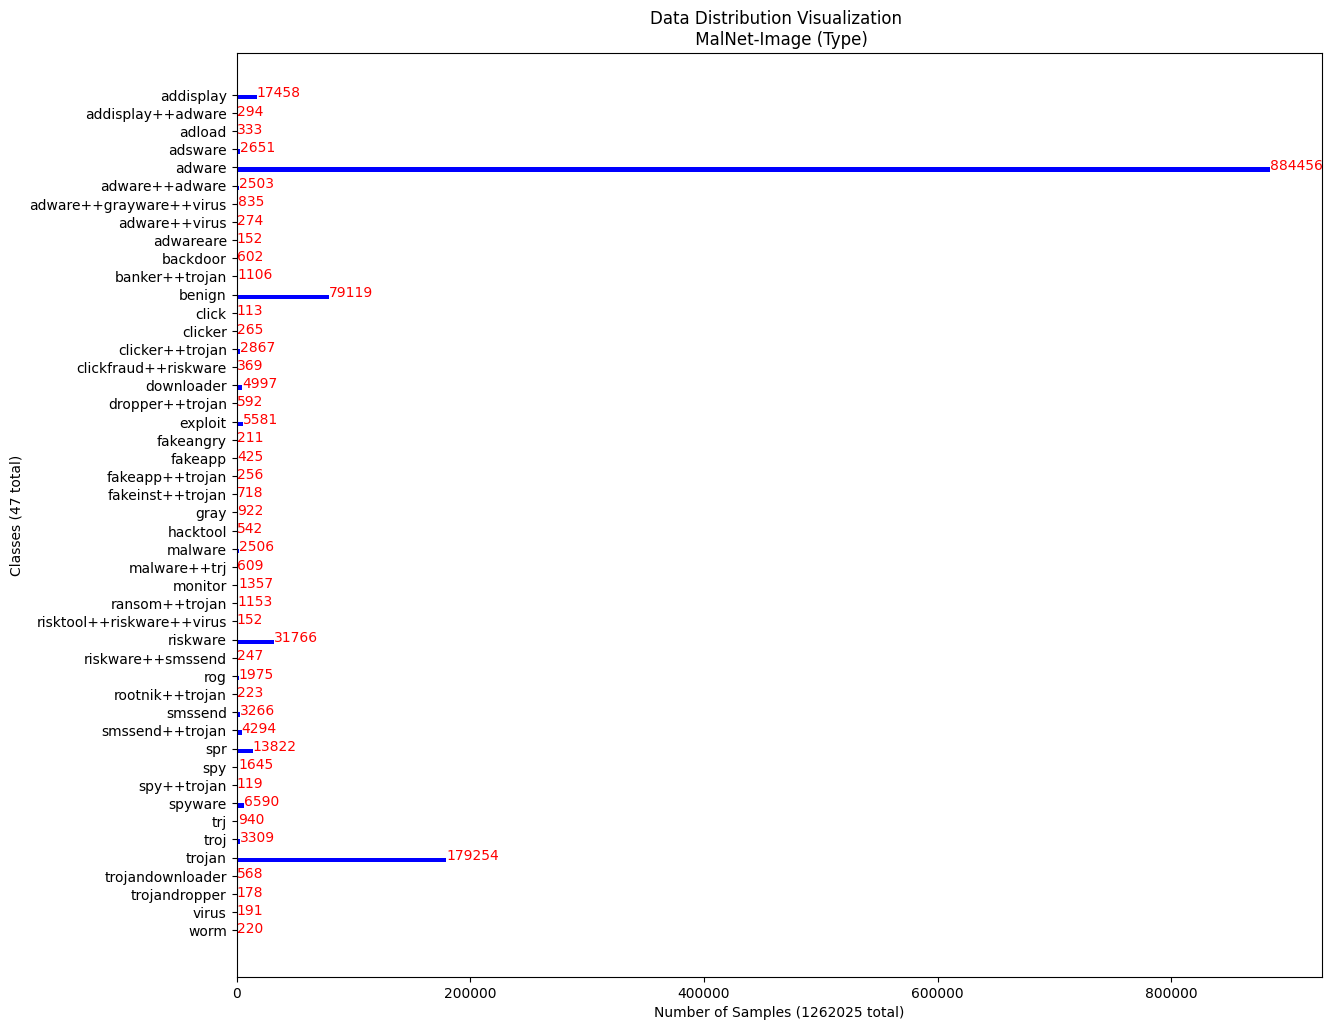

In [117]:
# Show Distribution
title="Data Distribution Visualization \n {} ({})".format(dataset_display_name, dataset_representation)
show_data_distribution(data_path_root, title, data_dist_fig_w, data_dist_fig_h)

# 6 . Data Resampling (Train Set)

## A . Undersample

### 0 . Utils

In [118]:
def undersample(train_path):

  # Get train dirs
  train_dirs = os.listdir(train_path)

  # Get number of samples
  # in minority class.
  minority_size = 1000000
  for train_dir in train_dirs:
    num_of_samples = len(os.listdir(train_path + '/' + train_dir))
    if num_of_samples < minority_size:
      minority_size = num_of_samples
  print('Minority class count: {}'.format(minority_size))

  # Remove samples such that all
  # classes have the same number
  # of samples as the minority class.
  print('Undersampling...')
  for train_dir in train_dirs:
    img_names = os.listdir(train_path + '/' + train_dir)
    num_of_samples = len(img_names)
    difference = num_of_samples - minority_size
    to_remove = random.sample(img_names, difference)
    for image in to_remove:
      os.remove(os.path.join(train_path, train_dir, image))
  print('Undersampling complete.')

### 1 . Undersample

In [119]:
# NOTE: Defined in Section 2-A-4-a

# Define undersampling
#under_sample_train = False

In [120]:
if under_sample_train:
  undersample(data_path_train)

## B . Oversample

### 0 . Utils

In [121]:
def oversample(train_path):

  # Get train dirs
  train_dirs = os.listdir(train_path)

  # Get number of samples
  # in majority class.
  majority_size = 0
  for train_dir in train_dirs:
    num_of_samples = len(os.listdir(train_path + '/' + train_dir))
    if num_of_samples > majority_size:
      majority_size = num_of_samples
  print('Majority class count: {}'.format(majority_size))

  # Reproduce samples such that all
  # classes have the same number
  # of samples as the majority class.
  print('Oversampling...')
  for train_dir in train_dirs:
    #print('Train Dir: {}'.format(train_dir))
    img_names = os.listdir(train_path + '/' + train_dir)
    count = 0
    while len(os.listdir(train_path + '/' + train_dir)) < majority_size:
      image = random.sample(img_names, 1)[0]
      #print(image)
      src  = os.path.join(train_path, train_dir, image)
      dest = os.path.join(train_path, train_dir, str(count)+image)
      shutil.copy(src, dest)
      count = count + 1
      #print(len(os.listdir(train_path + '/' + train_dir)))
  print('Undersampling complete.')

### 1 . Oversample

In [122]:
# NOTE: Defined in Section 2-A-4-b

# Define undersampling
#over_sample_train = False

In [123]:
if over_sample_train:
  oversample(data_path_train)

## C . Split Verification after Resample (Train/Val/Test)

In [124]:
# NOTE: Train count is expected to be less
#       than original after undersampling
#       and greater than original after
#       oversampling.

if under_sample_train or over_sample_train:
  show_train_val_test_split(data_path_root)

## D . Check Distribution

In [125]:
if under_sample_train or over_sample_train:
  # Show Distribution (Train)
  title="Data Distribution Visualization \n {} ({})".format(dataset_display_name, dataset_representation)
  show_data_distribution(data_path_root, title, data_dist_fig_w, data_dist_fig_h)

# 7 . Training Initialization

## A . Datablock

### 1 . Image Size

In [126]:
# All networks accept image size
# of 224 except for Inception.
img_size = 224
if 'Inception' in model_name:
  img_size = 299

### 2 . Initialize Datablock

In [127]:
# Define DataBlock
db_train_val = DataBlock(
                          blocks    = (ImageBlock, CategoryBlock),
                          get_items = get_image_files,
                          splitter  = GrandparentSplitter(train_name='train', valid_name='val'),
                          get_y     = parent_label,
                          item_tfms = Resize(img_size)
                        )

## B . Dataloader

### 1 . Batch Size

In [128]:
# NOTE: Defined in Section 2-B-1

# Define batch size
#batch_size = 64

### 2 . Sample Weights

#### a . Utils

In [129]:
# Gets a weight for each training sample
def get_train_sample_weights(training_labels, training_set):

  # Get number of samples per class
  count = Counter(training_labels)
  #print(training_labels)

  # Compute sample weights
  #
  # Code Ref:
  # https://www.kaggle.com/code/dienhoa/healthy-lung-classification-spectrogram-fast-ai/notebook
  print('Computing sample weights...')
  sample_wgts = [1/count[training_set.vocab[label]] for img, label in training_set]

  return sample_wgts

#### b . Definition

In [130]:
# NOTE: Defined in Section 2-B-2

# Define use sample weights
#use_sample_weights = False

#### c . Compute Sample Weights

In [131]:
# Init Sample Weights
sample_weights = None

if use_sample_weights:

  # Get sample weights
  sample_weights = get_train_sample_weights(get_train_sample_labels(data_path_train),
                                            db_train_val.datasets(data_path_root).train)

  print('Train Weights Length: {}'.format(len(sample_weights)))
  print('Train Weights (first 10): {}'.format(sample_weights[:10]))

### 3 . Initialize Dataloader

In [132]:
# Initialize Dataloaders
dls_train_val = None

if use_sample_weights:
  # Create dataloaders (weighted train loader)
  print('Initializing dataloaders with sample weights (train).')
  dls_train_val = db_train_val.dataloaders(data_path_root, dl_type=WeightedDL, wgts=sample_weights, bs=batch_size)

else:
  print('Initializing dataloaders without sample weights.')
  dls_train_val = db_train_val.dataloaders(data_path_root, bs=batch_size)

Initializing dataloaders without sample weights.


In [133]:
dls_one_batch_x, dls_one_batch_y = dls_train_val.one_batch()
#dls_train_val.one_batch()
sum(dls_one_batch_y)/len(dls_one_batch_y)

TensorCategory(12.9844, device='cuda:0')

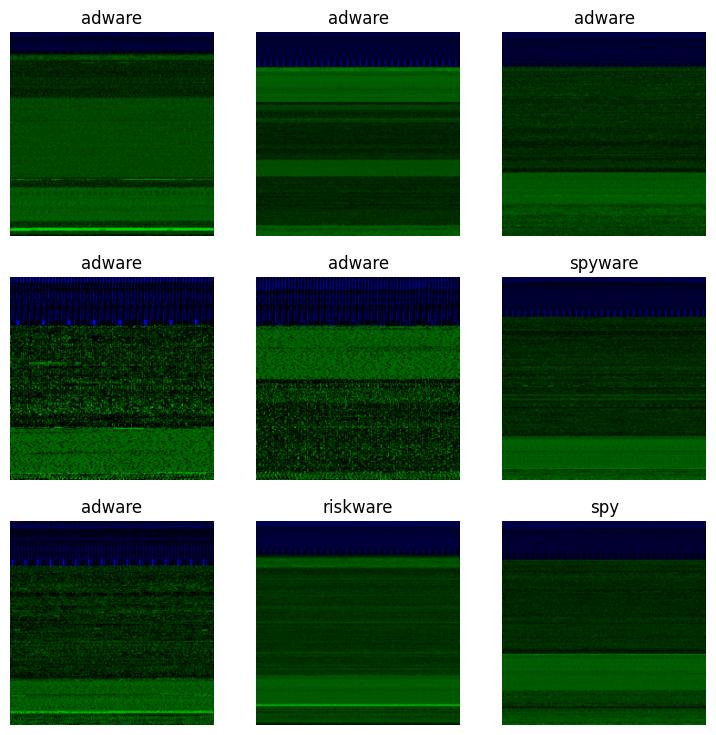

In [134]:
# Show 3 samples from training batch
if 'test' not in dataset:
  dls_train_val.train.show_batch(max_n=9, nrows=3)

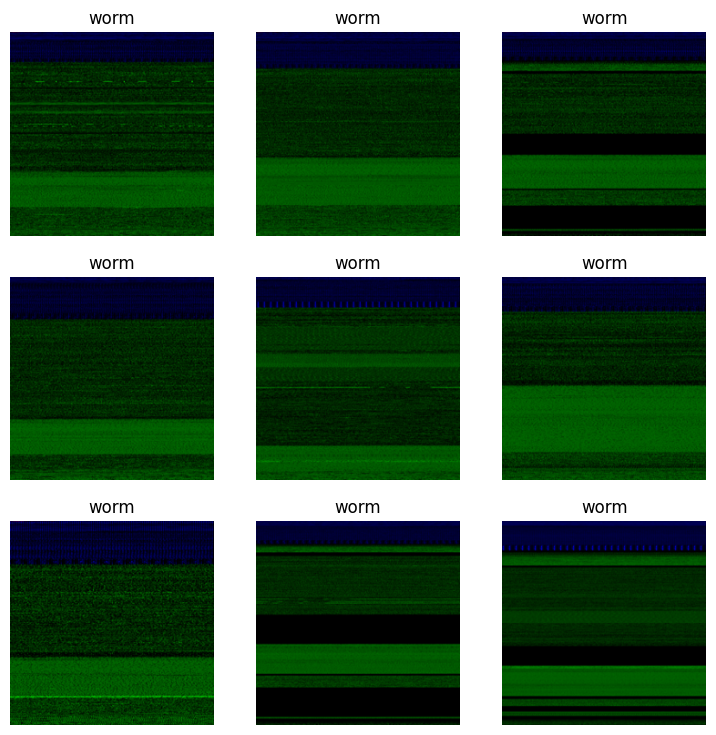

In [135]:
# Show 3 samples from validation batch
if 'test' not in dataset:
  dls_train_val.valid.show_batch(max_n=9, nrows=3)

## C . Learner

### 1 . Model

#### a . Utils

In [136]:
# Torch Models
def show_torch_models():
  return dir(models)

#show_torch_models()

In [137]:
# Timm Models
def show_timm_models():
  return timm.list_models()

#show_timm_models()

#### b . Definition

In [138]:
# NOTE: Defined in Section 2-C-1

# Define Model Name
#model_name = 'ResNet_18'

#### c . Initialization

In [139]:
# NOTE: There is a bugfix in work for EfficientNet models
# https://github.com/pytorch/vision/issues/7744#issuecomment-1757321451

from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

efficientnet_b4(weights=EfficientNet_B4_Weights.IMAGENET1K_V1)
efficientnet_b4(weights="DEFAULT")

efficientnet_b7(weights=EfficientNet_B7_Weights.IMAGENET1K_V1)
efficientnet_b7(weights="DEFAULT")

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-7eb33cd5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-7eb33cd5.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 144MB/s]
Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-dcc49843.pth
100%|██████████| 255M/255M [00:02<00:00, 124MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [140]:
# Init Model
model = ''

# Define Model
if 'DenseNet_121' in model_name:
	model = models.densenet121

if 'EfficientNet_b4' in model_name:
	model = models.efficientnet_b4

if 'EfficientNet_b7' in model_name:
	model = models.efficientnet_b7

if 'Inception_v3' in model_name:
	model = 'inception_v3'

if 'MobileNet_v2' in model_name:
	model = 'mobilenetv2_100'

if 'ResNet_18' in model_name:
	model = models.resnet18

if 'ResNet_50' in model_name:
	model = models.resnet50

if 'VGG_19_bn' in model_name:
	model = models.vgg19_bn

### 2 . Optimizer

#### a . Definition

In [141]:
# NOTE: Defined in Section 2-C-2

# Define Optimizer Name
#optimizer_name = 'Adam'

#### b . Initialization

In [142]:
# Init Optimizer
optimizer = ''

# Define optimizer
if 'Adam' in optimizer_name:
  optimizer = Adam
if 'SGD' in optimizer_name:
  optimizer = SGD

### 3 . Weight Decay

In [143]:
# NOTE: Defined in Section 2-C-3

# Define Weight Decay
#weight_decay_val = None

### 4 . Class Weights

#### a . Utils

In [144]:
# Gets a weight for each class
def get_class_weights(data_path):

  # Get train sample labels
  train_sample_labels = get_train_sample_labels(data_path_train)

  # Get class weights
  print('Computing class weights...')
  class_weights = class_weight.compute_class_weight(
                                                    class_weight = 'balanced',
                                                    classes      = np.unique(train_sample_labels),
                                                    y            = train_sample_labels
                                                   )

  # Create weight tensor and send to cuda
  class_weights = torch.tensor(class_weights).float().cuda()

  return class_weights

#### b . Definition

In [145]:
# NOTE: Defined in Section 2-C-4

# Define use class weights
#use_class_weights = False

#### c . Compute Class Weights

In [146]:
# Init Class Weights
class_weights = None

if use_class_weights:

    # Get class weights
    class_weights = get_class_weights(data_path_root)

### 5 . Loss Function

#### a . Definition

In [147]:
# NOTE: Defined in Section 2-C-5

# Define Loss Function
#loss_function_name = 'CrossEntropyLossFlat'

#### b . Initialization

In [148]:
#https://docs.fast.ai/losses.html

# Initialize Loss Function
loss_function = None

# Define Loss Function
if loss_function_name == 'CrossEntropyLoss':
  loss_function = nn.CrossEntropyLoss(weight=class_weights)

# Default, same as nn.CrossEntropyLoss,
# but flattens input and target.
# Same as loss_func == None
if loss_function_name == 'CrossEntropyLossFlat':
  loss_function = CrossEntropyLossFlat(weight=class_weights)

if loss_function_name == 'FocalLoss':
  loss_function = FocalLoss(weight=class_weights)

if loss_function_name == 'FocalLossFlat':
  loss_function = FocalLossFlat(weight=class_weights)

### 6 . Metrics

In [149]:
# NOTE: Classification Task is defined in section 4-A-5

# Init Metrics
classification_metrics = []

# Multiclass classification metrics
if classification_task == 'multi':
  classification_metrics = F1Score(average='macro')

# Binary classification metrics
if classification_task == 'binary':
  classification_metrics = [F1Score(average='macro'),
                            Precision(average='macro'),
                            Recall(average='macro')]

### 7 . Initialization

#### a . Check Defaults - vision_learner

In [150]:
# Check vision_learner defaults
# https://docs.fast.ai/vision.learner.html#vision_learner
??vision_learner

#### b . Initialize

In [151]:
# Initialize Learner
learner = vision_learner(
                          dls_train_val,
                          model,
                          opt_func  = optimizer,
                          wd        = weight_decay_val,
                          metrics   = classification_metrics,
                          loss_func = loss_function
                        )

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:04<00:00, 131MB/s]


## D . Summary

In [152]:
def show_training_initialization_vars():
  print('Training Initialization Vars:')

  print('\nDatablock:')
  print("\timg_size:                  {}".format(img_size))
  print("\tdb_train_val:              {}".format(db_train_val))

  print('\nDataloader:')
  print("\tbatch_size:                {}".format(batch_size))
  print("\tuse_sample_weights:        {}".format(use_sample_weights))
  if use_sample_weights:
    print("\tsample_weights (length):   {}".format(len(sample_weights)))
    print("\tsample_weights (first 10): {}".format(sample_weights[:10]))
  print("\tdls_train_val:             {}".format(dls_train_val))
  print("\tSample in Batch Prob:      {}".format(sum(dls_one_batch_y)/len(dls_one_batch_y)))

  print('\nLearner:')
  print("\tmodel_name:                {}".format(model_name))
  print("\tmodel:                     {}".format(model))
  print("\toptimizer_name:            {}".format(optimizer_name))
  print("\toptimizer:                 {}".format(optimizer))
  print("\tweight_decay_val:          {}".format(weight_decay_val))
  print("\tuse_class_weights:         {}".format(use_class_weights))
  if use_class_weights:
    print("\tclass_weights (length):    {}".format(len(class_weights)))
    print("\tclass_weights:             {}".format(class_weights))
  print("\tloss_function_name:        {}".format(loss_function_name))
  print("\tloss_function:             {}".format(loss_function))
  print("\tclassification_task:       {}".format(classification_task))
  print("\tclassification_metrics:    {}".format(classification_metrics))
  print("\tlearner:                   {}".format(learner))

show_training_initialization_vars()

Training Initialization Vars:

Datablock:
	img_size:                  224
	db_train_val:              <fastai.data.block.DataBlock object at 0x7c4204291e70>

Dataloader:
	batch_size:                64
	use_sample_weights:        False
	dls_train_val:             <fastai.data.core.DataLoaders object at 0x7c42033450c0>
	Sample in Batch Prob:      TensorCategory(12.9844, device='cuda:0')

Learner:
	model_name:                VGG_19_bn
	model:                     <function vgg19_bn at 0x7c426b83fe20>
	optimizer_name:            Adam
	optimizer:                 <function Adam at 0x7c423ecc9bd0>
	weight_decay_val:          None
	use_class_weights:         False
	loss_function_name:        CrossEntropyLossFlat
	loss_function:             FlattenedLoss of CrossEntropyLoss()
	classification_task:       multi
	classification_metrics:    <fastai.metrics.AccumMetric object at 0x7c4226737a60>
	learner:                   <fastai.learner.Learner object at 0x7c42265dac80>


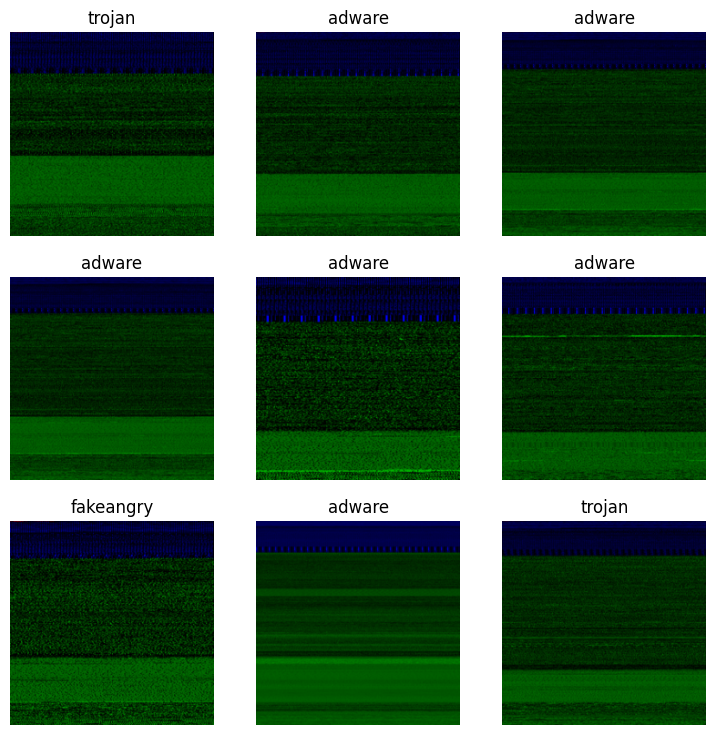

In [153]:
# Show 3 samples from training batch
if 'test' not in dataset:
  dls_train_val.train.show_batch(max_n=9, nrows=3)

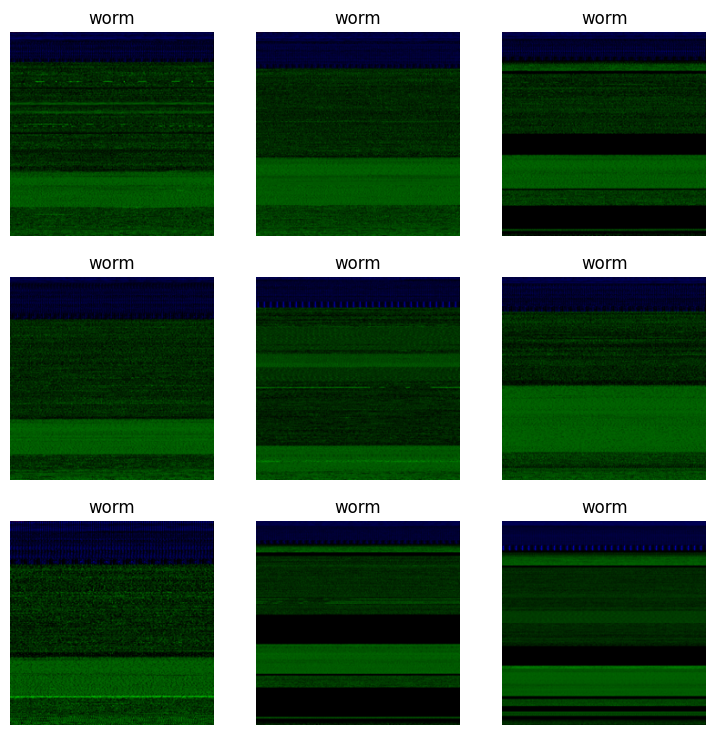

In [154]:
# Show 3 samples from validation batch
if 'test' not in dataset:
  dls_train_val.valid.show_batch(max_n=9, nrows=3)

In [155]:
# Display model architecture
learner.model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

In [156]:
# Display model summary
learner.summary()

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 224 x 224 
Conv2d                                    1792       False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36928      False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 112 x 112 
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 128 x 112 x 11 
Conv2d                                    73856      False     
BatchNorm2d                               256        True      
ReLU                               

# 8 . Training and Validation

## A . Current Configuration (Comprehensive Summary)

### 1 . Environment Setup Summary

In [157]:
# Environment Setup Summary
show_env_setup_vars()

Environment Setup Vars:

Google Drive:
	google_drive:                         /content/drive

Environment Seed:
	env_seed:                             9750

Project Root:
	poject_name:                          EJBarbin-MastersThesis-AndroidMalwareDetectionAndClassification
	drive_dir_project_root:               /content/drive/MyDrive/EJBarbin-MastersThesis-AndroidMalwareDetectionAndClassification
	sym_link_project_root:                ./Thesis

Dataset Archive:
	drive_dir_datasets:                   ./Thesis/Datasets
	drive_dir_datasets_malnet_image:      ./Thesis/Datasets/MalNet-Image
	drive_dir_datasets_malnet_image_tiny: ./Thesis/Datasets/MalNet-Image-Tiny
	drive_dir_datasets_rgb_test:          ./Thesis/Datasets/RGB-Test

Results Archive:
	drive_dir_results:                    ./Thesis/Results


### 2 . Training Configuration Summary

In [158]:
# Training Configuration Summary
show_training_config_vars()

Training Configuration Vars:

Dataset:
	dataset:                    malnet-images
	dataset_representation:     Type
	split_pct_val_test:         0.2
	split_pct_test:             0.5
	under_sample_full:           False
	under_sample_train:          False
	over_sample_train:           False

Dataloader:
	batch_size:                 64
	use_sample_weights:         False

Learner:
	model_name:                 VGG_19_bn
	optimizer_name:             Adam
	weight_decay_val:           None
	use_class_weights:          False
	loss_function_name:         CrossEntropyLossFlat

Training:

	Fine Tune:
	freeze_param_fine_tune:     2
	droput_p1_fine_tune:        0.25
	droput_p2_fine_tune:        0.5
	use_suggested_lr_fine_tune: False
	lr_fine_tune:               0.002
	epochs_fine_tune:           0
	freeze_epochs_fine_tune:    1

	Fit:
	freeze_param_fit:           0
	droput_p1_fit:              0.25
	droput_p2_fit:              0.5
	use_suggested_lr_fit:       True
	lr_fit:                     0.002


### 3 . Data Preparation Summary

In [159]:
# Dataset Preparation Summary
show_dataset_preparation_vars()

Dataset Preparation Vars:

MalNet-Image:
	fragment_malnet_images:                       malnet-image{0}
	download_url_malnet_images:                   http://malnet.cc.gatech.edu/image-data/full-data-as-1GB/malnet-image{0}
	archive_path_fragments_malnet_images:         ./Thesis/Datasets/MalNet-Image/malnet-image{0}
	local_dir_malnet_images:                      ./malnet-images

MalNet-Image Tiny:
	tarball_malnet_images_tiny:                   malnet-images-tiny.tar.gz
	tarball_malnet_images_tiny_gray:              malnet-images-tiny-gray.tar.gz
	tarball_malnet_images_tiny_rgb:               malnet-images-tiny-rgb.tar.gz
	download_url_malnet_images_tiny:              http://malnet.cc.gatech.edu/image-data/malnet-images-tiny.tar.gz
	archive_path_tarball_malnet_images_tiny:      ./Thesis/Datasets/MalNet-Image-Tiny/malnet-images-tiny.tar.gz
	archive_path_tarball_malnet_images_tiny_gray: ./Thesis/Datasets/MalNet-Image-Tiny/malnet-images-tiny-gray.tar.gz
	archive_path_tarball_malnet_images_t

### 4 . Data Initialization Summary

In [160]:
# Data Initialization Summary
show_data_initialization_vars()

Data Initialization Vars:
	dataset:                malnet-images
	data_path_root:         ./malnet-images
	data_path_train:        ./malnet-images/train
	data_path_val:          ./malnet-images/val
	data_path_test:         ./malnet-images/test
	dataset_display_name:   MalNet-Image
	dataset_representation: Type
	classification_task:    multi
	data_dist_fig_w:        14
	data_dist_fig_h:        12
	cf_matrix_fig_size:     32
	split_pct_val_test:     0.2
	split_pct_test:         0.5
	class_labels_unique:    ['addisplay', 'addisplay++adware', 'adload', 'adsware', 'adware', 'adware++adware', 'adware++grayware++virus', 'adware++virus', 'adwareare', 'backdoor', 'banker++trojan', 'benign', 'click', 'clicker', 'clicker++trojan', 'clickfraud++riskware', 'downloader', 'dropper++trojan', 'exploit', 'fakeangry', 'fakeapp', 'fakeapp++trojan', 'fakeinst++trojan', 'gray', 'hacktool', 'malware', 'malware++trj', 'monitor', 'ransom++trojan', 'risktool++riskware++virus', 'riskware', 'riskware++smssend', '

In [161]:
# Show stats for active dataset
show_dir_stats(data_path_root)

Dirs:       ['test', 'train', 'val']
Dir Count:  3
File Count: 1262025
Total Size: 81.8 GB


In [162]:
# Show split stats for active dataset
show_train_val_test_split(data_path_root)

Checking Stats for: ./malnet-images
Dirs:       ['test', 'train', 'val']
Dir Count:  3
File Count: 1262025
Total Size: 81.8 GB

Checking Stats for: ./malnet-images/train
Dirs:       ['addisplay', 'addisplay++adware', 'adload', 'adsware', 'adware', 'adware++adware', 'adware++grayware++virus', 'adware++virus', 'adwareare', 'backdoor', 'banker++trojan', 'benign', 'click', 'clicker', 'clicker++trojan', 'clickfraud++riskware', 'downloader', 'dropper++trojan', 'exploit', 'fakeangry', 'fakeapp', 'fakeapp++trojan', 'fakeinst++trojan', 'gray', 'hacktool', 'malware', 'malware++trj', 'monitor', 'ransom++trojan', 'risktool++riskware++virus', 'riskware', 'riskware++smssend', 'rog', 'rootnik++trojan', 'smssend', 'smssend++trojan', 'spr', 'spy', 'spy++trojan', 'spyware', 'trj', 'troj', 'trojan', 'trojandownloader', 'trojandropper', 'virus', 'worm']
Dir Count:  47
File Count: 1009620
Total Size: 65.4 GB

Checking Stats for: ./malnet-images/val
Dirs:       ['addisplay', 'addisplay++adware', 'adload', '

### 5 . Data Distribution Summary

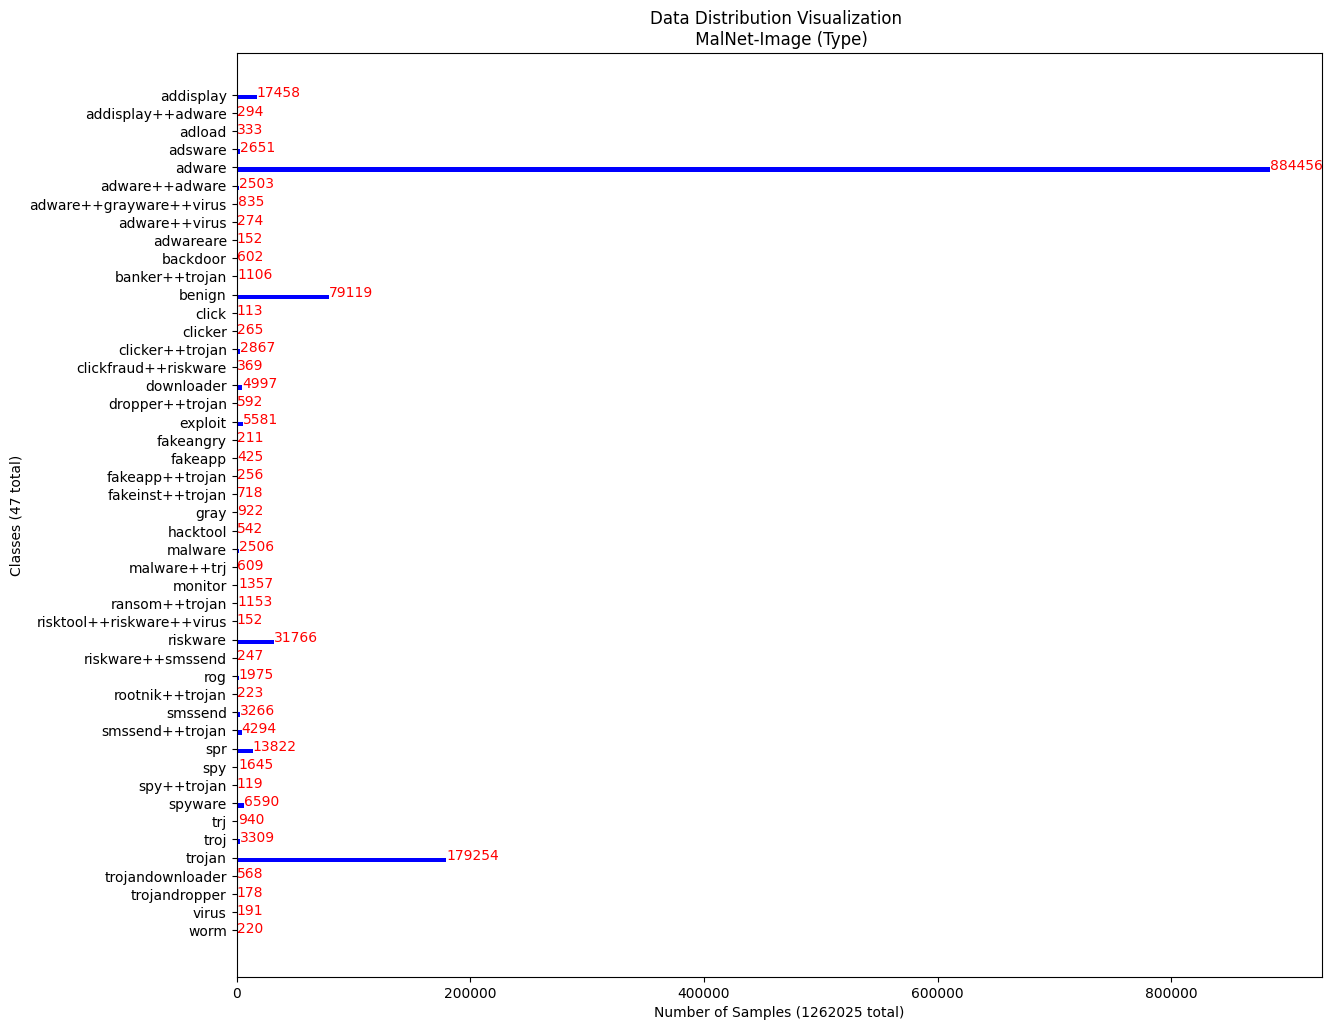

In [163]:
# Show Distribution
title="Data Distribution Visualization \n {} ({})".format(dataset_display_name, dataset_representation)
show_data_distribution(data_path_root, title, data_dist_fig_w, data_dist_fig_h)

### 6 . Training Initialization Summary

In [164]:
# Training Initialization Summary
show_training_initialization_vars()

Training Initialization Vars:

Datablock:
	img_size:                  224
	db_train_val:              <fastai.data.block.DataBlock object at 0x7c4204291e70>

Dataloader:
	batch_size:                64
	use_sample_weights:        False
	dls_train_val:             <fastai.data.core.DataLoaders object at 0x7c42033450c0>
	Sample in Batch Prob:      TensorCategory(12.9844, device='cuda:0')

Learner:
	model_name:                VGG_19_bn
	model:                     <function vgg19_bn at 0x7c426b83fe20>
	optimizer_name:            Adam
	optimizer:                 <function Adam at 0x7c423ecc9bd0>
	weight_decay_val:          None
	use_class_weights:         False
	loss_function_name:        CrossEntropyLossFlat
	loss_function:             FlattenedLoss of CrossEntropyLoss()
	classification_task:       multi
	classification_metrics:    <fastai.metrics.AccumMetric object at 0x7c4226737a60>
	learner:                   <fastai.learner.Learner object at 0x7c42265dac80>


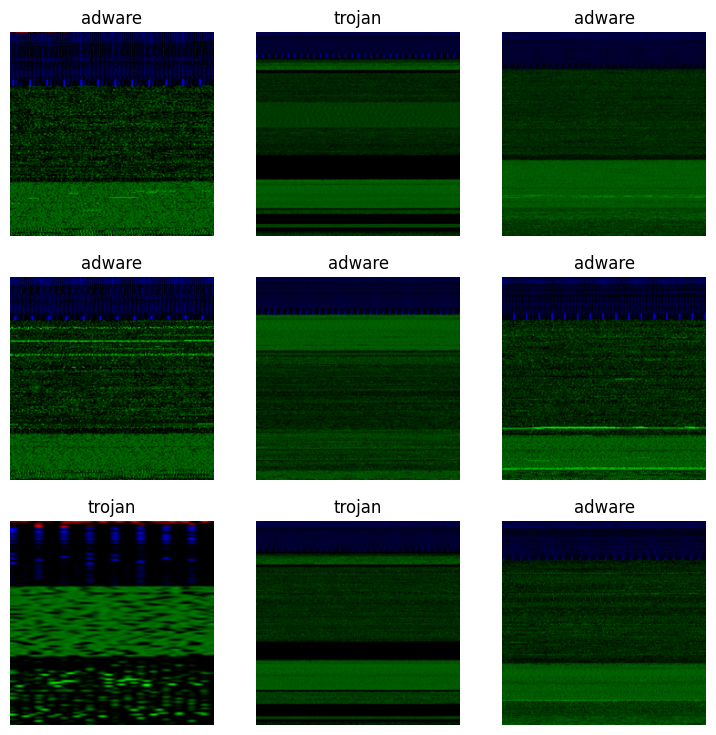

In [165]:
# Show 3 samples from training batch
if 'test' not in dataset:
  dls_train_val.train.show_batch(max_n=9, nrows=3)

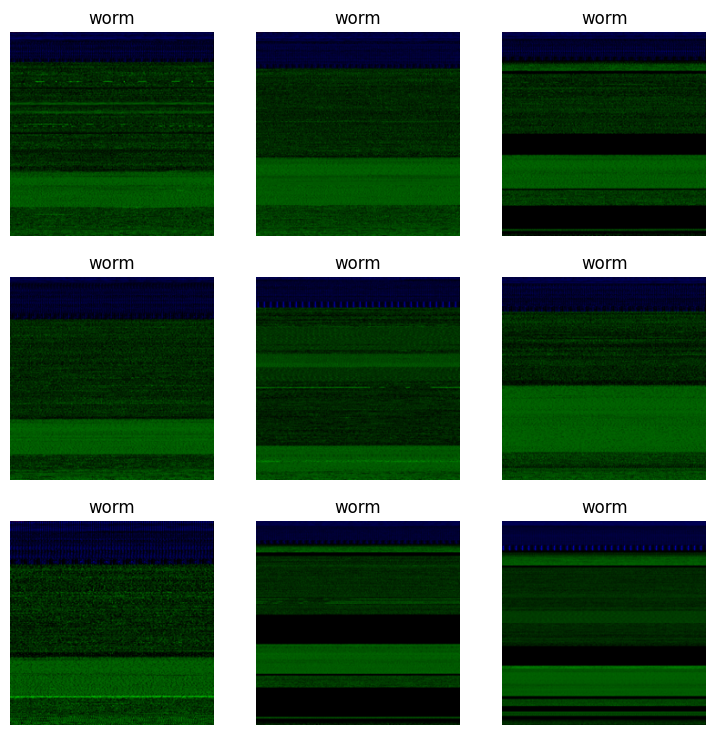

In [166]:
# Show 3 samples from validation batch
if 'test' not in dataset:
  dls_train_val.valid.show_batch(max_n=9, nrows=3)

In [167]:
# Display model architecture
learner.model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

In [168]:
# Display model summary
learner.summary()

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 224 x 224 
Conv2d                                    1792       False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36928      False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 112 x 112 
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 128 x 112 x 11 
Conv2d                                    73856      False     
BatchNorm2d                               256        True      
ReLU                               

## B . Fine Tune

### 0 . Check Defaults - fine_tune

In [169]:
# Check fine_tune defaults
# https://docs.fast.ai/callback.schedule.html#learner.fine_tune
??learner.fine_tune

### 1 . Freeze

In [170]:
# NOTE: Defined in Section 2-D-1-a

# Freeze all but last layer
#freeze_param_fine_tune = 2 # Default

In [171]:
# Freeze parameter group
learner.freeze_to(freeze_param_fine_tune)

In [172]:
# Verify model
#learner.model

In [173]:
# Verify freeze param
learner.summary()

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 224 x 224 
Conv2d                                    1792       False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36928      False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 112 x 112 
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 128 x 112 x 11 
Conv2d                                    73856      False     
BatchNorm2d                               256        True      
ReLU                               

### 2 . Dropout

In [174]:
# NOTE: Defined in Section 2-D-1-b

# Define Dropout p1
#droput_p1_fine_tune = 0.25 # Default

In [175]:
# NOTE: Defined in Section 2-D-1-b

# Define Dropout p2
#droput_p2_fine_tune = 0.5 # Default

In [176]:
# Modifications
learner.model[1][3].p = droput_p1_fine_tune
learner.model[1][7].p = droput_p2_fine_tune

In [177]:
# Verify Dropout
learner.model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

In [178]:
# Display model summary
#learner.summary()

### 3 . Learning Rate

In [179]:
# NOTE: Defined in Section 2-D-1-c

# Define whether to use Suggested LR
# use_suggested_lr_fine_tune = False

In [180]:
# NOTE: Defined in Section 2-D-1-c

# Define LR
# lr_fine_tune = 0.002 # Default

In [181]:
# Get Suggested learning rate
if use_suggested_lr_fine_tune:
  lr_fine_tune = learner.lr_find().valley

# Verify Learning Rate
print('use_suggested_lr_fine_tune: {}'.format(use_suggested_lr_fine_tune))
print('lr_fine_tune:               {}'.format(lr_fine_tune))

use_suggested_lr_fine_tune: False
lr_fine_tune:               0.002


### 4 . Epochs

In [182]:
# NOTE: Defined in Section 2-D-1-d

# Define fine tune epochs
#epochs_fine_tune = 0 # Do not train unfrozen

In [183]:
# NOTE: Defined in Section 2-D-1-d

# Define fine tune freeze epochs
# Train last layer for x epochs
#freeze_epochs_fine_tune = 1

### 5 . Fine Tune

In [184]:
# Fine tune last layer
learner.fine_tune(
                    base_lr       = lr_fine_tune,
                    epochs        = epochs_fine_tune,
                    freeze_epochs = freeze_epochs_fine_tune
                 )

## C . Fit

### 0 . Check Defaults - fit_one_cycle

In [185]:
# Check fit_one_cycle defaults
# https://docs.fast.ai/callback.schedule.html#learner.fit_one_cycle
??learner.fit_one_cycle

### 1 . Freeze

In [186]:
# NOTE: Defined in Section 2-D-2-a

# Define fit freeze param
#freeze_param_fit = 0 # Unfreeze, default

In [187]:
# Freeze parameter group
learner.freeze_to(freeze_param_fit)

In [188]:
# Verify model
#learner.model

In [189]:
# Verify freeze param
learner.summary()

/usr/local/lib/python3.10/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 224 x 224 
Conv2d                                    1792       True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36928      True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 112 x 112 
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 128 x 112 x 11 
Conv2d                                    73856      True      
BatchNorm2d                               256        True      
ReLU                               

### 2 . Dropout

In [190]:
# NOTE: Defined in Section 2-D-2-b

# Define Dropout p1
#droput_p1_fit = 0.25 # Default

In [191]:
# NOTE: Defined in Section 2-D-2-b

# Define Dropout p2
#droput_p2_fit = 0.5 # Default

In [192]:
# Modifications
learner.model[1][3].p = droput_p1_fit
learner.model[1][7].p = droput_p2_fit

In [193]:
# Verify Dropout
learner.model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

In [194]:
# Display model summary
#learner.summary()

### 3 . Learning Rate

In [195]:
# NOTE: Defined in Section 2-D-2-c

# Define whether to use Suggested LR
# use_suggested_lr_fit = False

In [196]:
# NOTE: Defined in Section 2-D-2-c

# Define LR
# lr_fit = 0.002

use_suggested_lr_fit: True
lr_fit:               1.737800812406931e-05


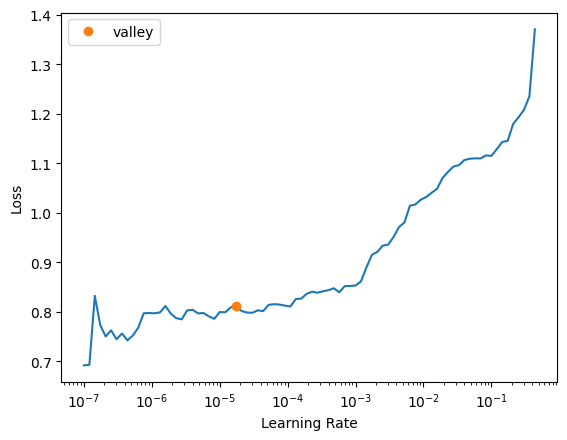

In [197]:
# Get Suggested learning rate
if use_suggested_lr_fit:
  lr_fit = learner.lr_find().valley

print('use_suggested_lr_fit: {}'.format(use_suggested_lr_fit))
print('lr_fit:               {}'.format(lr_fit))

In [198]:
# NOTE: Defined in Section 2-D-2-c

# Define whether to use LR Slices
#use_lr_slices_fit = True

In [199]:
# Get lr slices
if use_lr_slices_fit:

  # Get lr exponent
  lr_exp = float(np.floor(np.log10(np.abs(lr_fit))))

  # Compute bottom and top of lr slices
  lr_bottom = 10 * 10 ** lr_exp
  lr_top    = 10 * 10 ** (lr_exp + 1)

  print('Bottom LR slice: {}'.format(lr_bottom))
  print('Top LR slice: {}'.format(lr_top))

  lr_fit = slice(lr_bottom, lr_top)

print('use_lr_slices_fit: {}'.format(use_lr_slices_fit))
print('lr_fit:            {}'.format(lr_fit))

Bottom LR slice: 0.0001
Top LR slice: 0.001
use_lr_slices_fit: True
lr_fit:            slice(0.0001, 0.001, None)


### 4 . Epochs

In [200]:
# NOTE: Defined in Section 2-D-2-d

# Define fit epochs
#epochs_fit = 39

In [201]:
# NOTE: Defined in Section 2-D-2-d

# Define patience level
#patience_level_fit = 3

In [202]:
# NOTE: Defined in Section 2-D-2-d

# Define epoch min delta
#epoch_min_delta_fit = 0.01

### 5 . Fit

Better model found at epoch 0 with f1_score value: 0.29694552713891254.


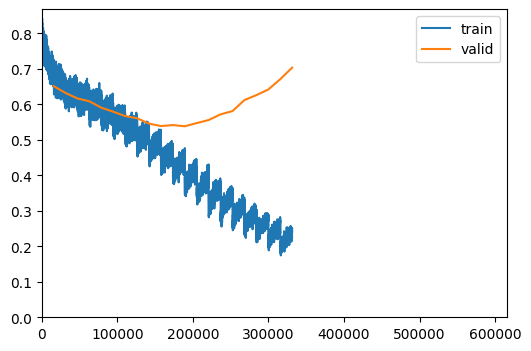

Better model found at epoch 2 with f1_score value: 0.30835308647307963.
Better model found at epoch 3 with f1_score value: 0.3219964970557184.
Better model found at epoch 4 with f1_score value: 0.32291126426132094.
Better model found at epoch 5 with f1_score value: 0.33090580350708787.
Better model found at epoch 6 with f1_score value: 0.3522073895417186.
Better model found at epoch 7 with f1_score value: 0.3635076694797414.
Better model found at epoch 9 with f1_score value: 0.39103735051363964.
Better model found at epoch 10 with f1_score value: 0.409251015205873.
Better model found at epoch 11 with f1_score value: 0.42135884725063405.
Better model found at epoch 12 with f1_score value: 0.4219207884637065.
Better model found at epoch 13 with f1_score value: 0.43389397762487836.
Better model found at epoch 14 with f1_score value: 0.45130080582612.
Better model found at epoch 16 with f1_score value: 0.4628019789691508.
Better model found at epoch 18 with f1_score value: 0.47769684478700

In [203]:
# Fit the model
learner.fit_one_cycle(
                      epochs_fit,
                      lr_fit,
                      cbs = [
                              ShowGraphCallback(),
                              EarlyStoppingCallback(
                                                    monitor   = 'f1_score',
                                                    patience  = patience_level_fit,
                                                    min_delta = epoch_min_delta_fit,
                                                    comp      = np.greater
                                                   ),
                              SaveModelCallback(
                                                monitor = 'f1_score',
                                                comp    = np.greater
                                               )
                            ]
                      )

## D . Validate

In [204]:
# Validate learner
learner.validate()

(#2) [0.6709062457084656,0.4779498871616073]

# 9 . Save Predictions and Ground Truths (Validation and Test)

## A . Utility Functions

In [205]:
def save_preds_and_gts(data_loader, save_location_results, class_labels, classification_task, cf_matrix_fig_size, class_type):

  # Get prediction probabilities and ground truths from data loader
  pred_probs, gts = learner.get_preds(dl=data_loader)

  # Create list of data to save
  savedata = [pred_probs, gts, class_labels, classification_task, cf_matrix_fig_size]

  # Save data as a pickle.
  with open("{}-{}.pkl".format(save_location_results, class_type), 'wb') as outfile:
      pickle.dump(savedata, outfile, pickle.HIGHEST_PROTOCOL)

## B . Save Data

In [206]:
# Save model
#learner.save(save_data_location)

In [207]:
# Save Prediction Probabilities and Ground Truths - Validation
save_preds_and_gts(dls_train_val[1], save_location_results, class_labels_unique, classification_task, cf_matrix_fig_size, 'Validation')

In [208]:
# Create test data loader
test_dl = learner.dls.test_dl(get_image_files(data_path_test), with_labels=True)

# Save Prediction Probabilities and Ground Truths - Test
save_preds_and_gts(test_dl, save_location_results, class_labels_unique, classification_task, cf_matrix_fig_size, 'Test')

# 10 . Load Predictions and Ground Truths (Validation and Test)

## A . Utility Functions

In [209]:
def load_preds_and_gts(save_location_results, class_type):
  with open("{}-{}.pkl".format(save_location_results, class_type), 'rb') as infile:
    pred_probs, gts, class_labels_unique, classification_task, cf_matrix_fig_size = pickle.load(infile)
    return pred_probs, gts, class_labels_unique, classification_task, cf_matrix_fig_size

## B . Load Data

In [210]:
# For each classification type, load each of the 16 model val predictions
  # Compute and save f1-score from sklearn library (or fastai f1_score()) for each using predictions and ground truths (Need to show table for thesis)
  # Save and display in list and name of model (will be displayed in results - highlight row with best f1_score)

In [211]:
# Load model
#learner.load(save_data_location)

In [212]:
# Load Prediction Probabilities and Ground Truths - Validation
pred_probs_val, gts_val, class_labels_unique, classification_task, cf_matrix_fig_size = load_preds_and_gts(save_location_results, 'Validation')

In [213]:
# Load Prediction Probabilities and Ground Truths - Test
pred_probs_test, gts_test, class_labels_unique, classification_task, cf_matrix_fig_size = load_preds_and_gts(save_location_results, 'Test')

# 11 . Calculate Metrics

## A . Utils

In [214]:
def get_f1_score(gts, pred_probs):
  return f1_score(y_true=gts, y_pred=np.argmax(pred_probs, axis=1), average='macro')

In [215]:
def get_precision(gts, pred_probs):
  if classification_task == 'binary':
    return precision_score(y_true=gts, y_pred=np.argmax(pred_probs, axis=1), average='macro')
  else:
    return None

In [216]:
def get_recall(gts, pred_probs):
  if classification_task == 'binary':
    return recall_score(y_true=gts, y_pred=np.argmax(pred_probs, axis=1), average='macro')
  else:
    return None

In [217]:
def display_metrics(gts, pred_probs):

  f1_score  = get_f1_score(gts, pred_probs)
  precision = get_precision(gts, pred_probs)
  recall    = get_recall(gts, pred_probs)

  print('F1-Score:  {}'.format(f1_score))
  print('Precision: {}'.format(precision))
  print('Recall:    {}'.format(recall))

In [218]:
def plot_confusion_matrix(cm,
                          class_labels_unique,
                          title, # Title of plot
                          class_type,
                          normalize:bool=False, # Whether to normalize occurrences
                          cmap:str="Blues", # Colormap from matplotlib
                          norm_dec:int=2, # Decimal places for normalized occurrences
                          plot_txt:bool=True, # Display occurrence in matrix
                          **kwargs
                          ):

    "Plot the confusion matrix, with `title` and using `cmap`."
    # This function is mainly copied from the sklearn docs
    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig = plt.figure(**kwargs)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix ({}) \n {}'.format(class_type, title))
    tick_marks = np.arange(len(class_labels_unique))
    plt.xticks(tick_marks, class_labels_unique, rotation=90)
    plt.yticks(tick_marks, class_labels_unique, rotation=0)

    if plot_txt:
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            coeff = f'{cm[i, j]:.{norm_dec}f}' if normalize else f'{cm[i, j]}'
            plt.text(j, i, coeff, horizontalalignment="center", verticalalignment="center", color="white"
                      if cm[i, j] > thresh else "black")

    ax = fig.gca()
    ax.set_ylim(len(class_labels_unique)-.5,-.5)

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.grid(False)

In [219]:
def display_confusion_matrix(gts, pred_probs, class_labels_unique, title, class_type, cf_matrix_fig_size):
  cf_matrix = confusion_matrix(y_true=gts, y_pred=np.argmax(pred_probs, axis=1))
  print(plot_confusion_matrix(cf_matrix, class_labels_unique, title, class_type, figsize=(cf_matrix_fig_size, cf_matrix_fig_size)))

In [220]:
# ROC AUC - Binary Classification
def get_roc_auc_binary_classification(gts, pred_probs, title, class_type):

  RocCurveDisplay.from_predictions(
                                    y_true = gts,
                                    y_pred = np.argmax(pred_probs, axis=1),
                                    name   = class_type,
                                    color  = "DarkOrange"
                                  )

  plt.title('ROC Curve ({}) \n {}'.format(class_type, title))

In [221]:
# ROC AUC - Multiclass Classification
# https://www.youtube.com/watch?v=wyCswvH_4kg
# https://github.com/vappiah/Machine-Learning-Tutorials/blob/main/notebooks/ROC_Multiclass_Random_Forest.ipynb
def get_roc_auc_multiclass_classification(gts, pred_probs, class_labels_unique, title, class_type):

  y_test_binarized=label_binarize(gts,classes=np.unique(gts))

  fpr={}
  tpr={}
  roc_auc={}

  for i in range(pred_probs.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:,i], pred_probs[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # plotting
    plt.plot(fpr[i], tpr[i], linestyle='--',
              label='%s vs Rest (AUC=%0.2f)'%(class_labels_unique[i],roc_auc[i]))

  plt.plot([0,1],[0,1],'b--')
  plt.xlim([0,1])
  plt.ylim([0,1.05])
  plt.title('Multiclass ROC Curve ({}) \n {}'.format(class_type, title))
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.show()

In [222]:
def get_roc_auc(gts, pred_probs, class_labels_unique, title, class_type):
  if classification_task == 'binary':
    print(get_roc_auc_binary_classification(gts, pred_probs, title, class_type))
  else:
    if classification_task == 'multi':
      print(get_roc_auc_multiclass_classification(gts, pred_probs, class_labels_unique, title, class_type))

## B . Validation

In [223]:
display_metrics(gts_val, pred_probs_val)

F1-Score:  0.4779498871616073
Precision: None
Recall:    None


None


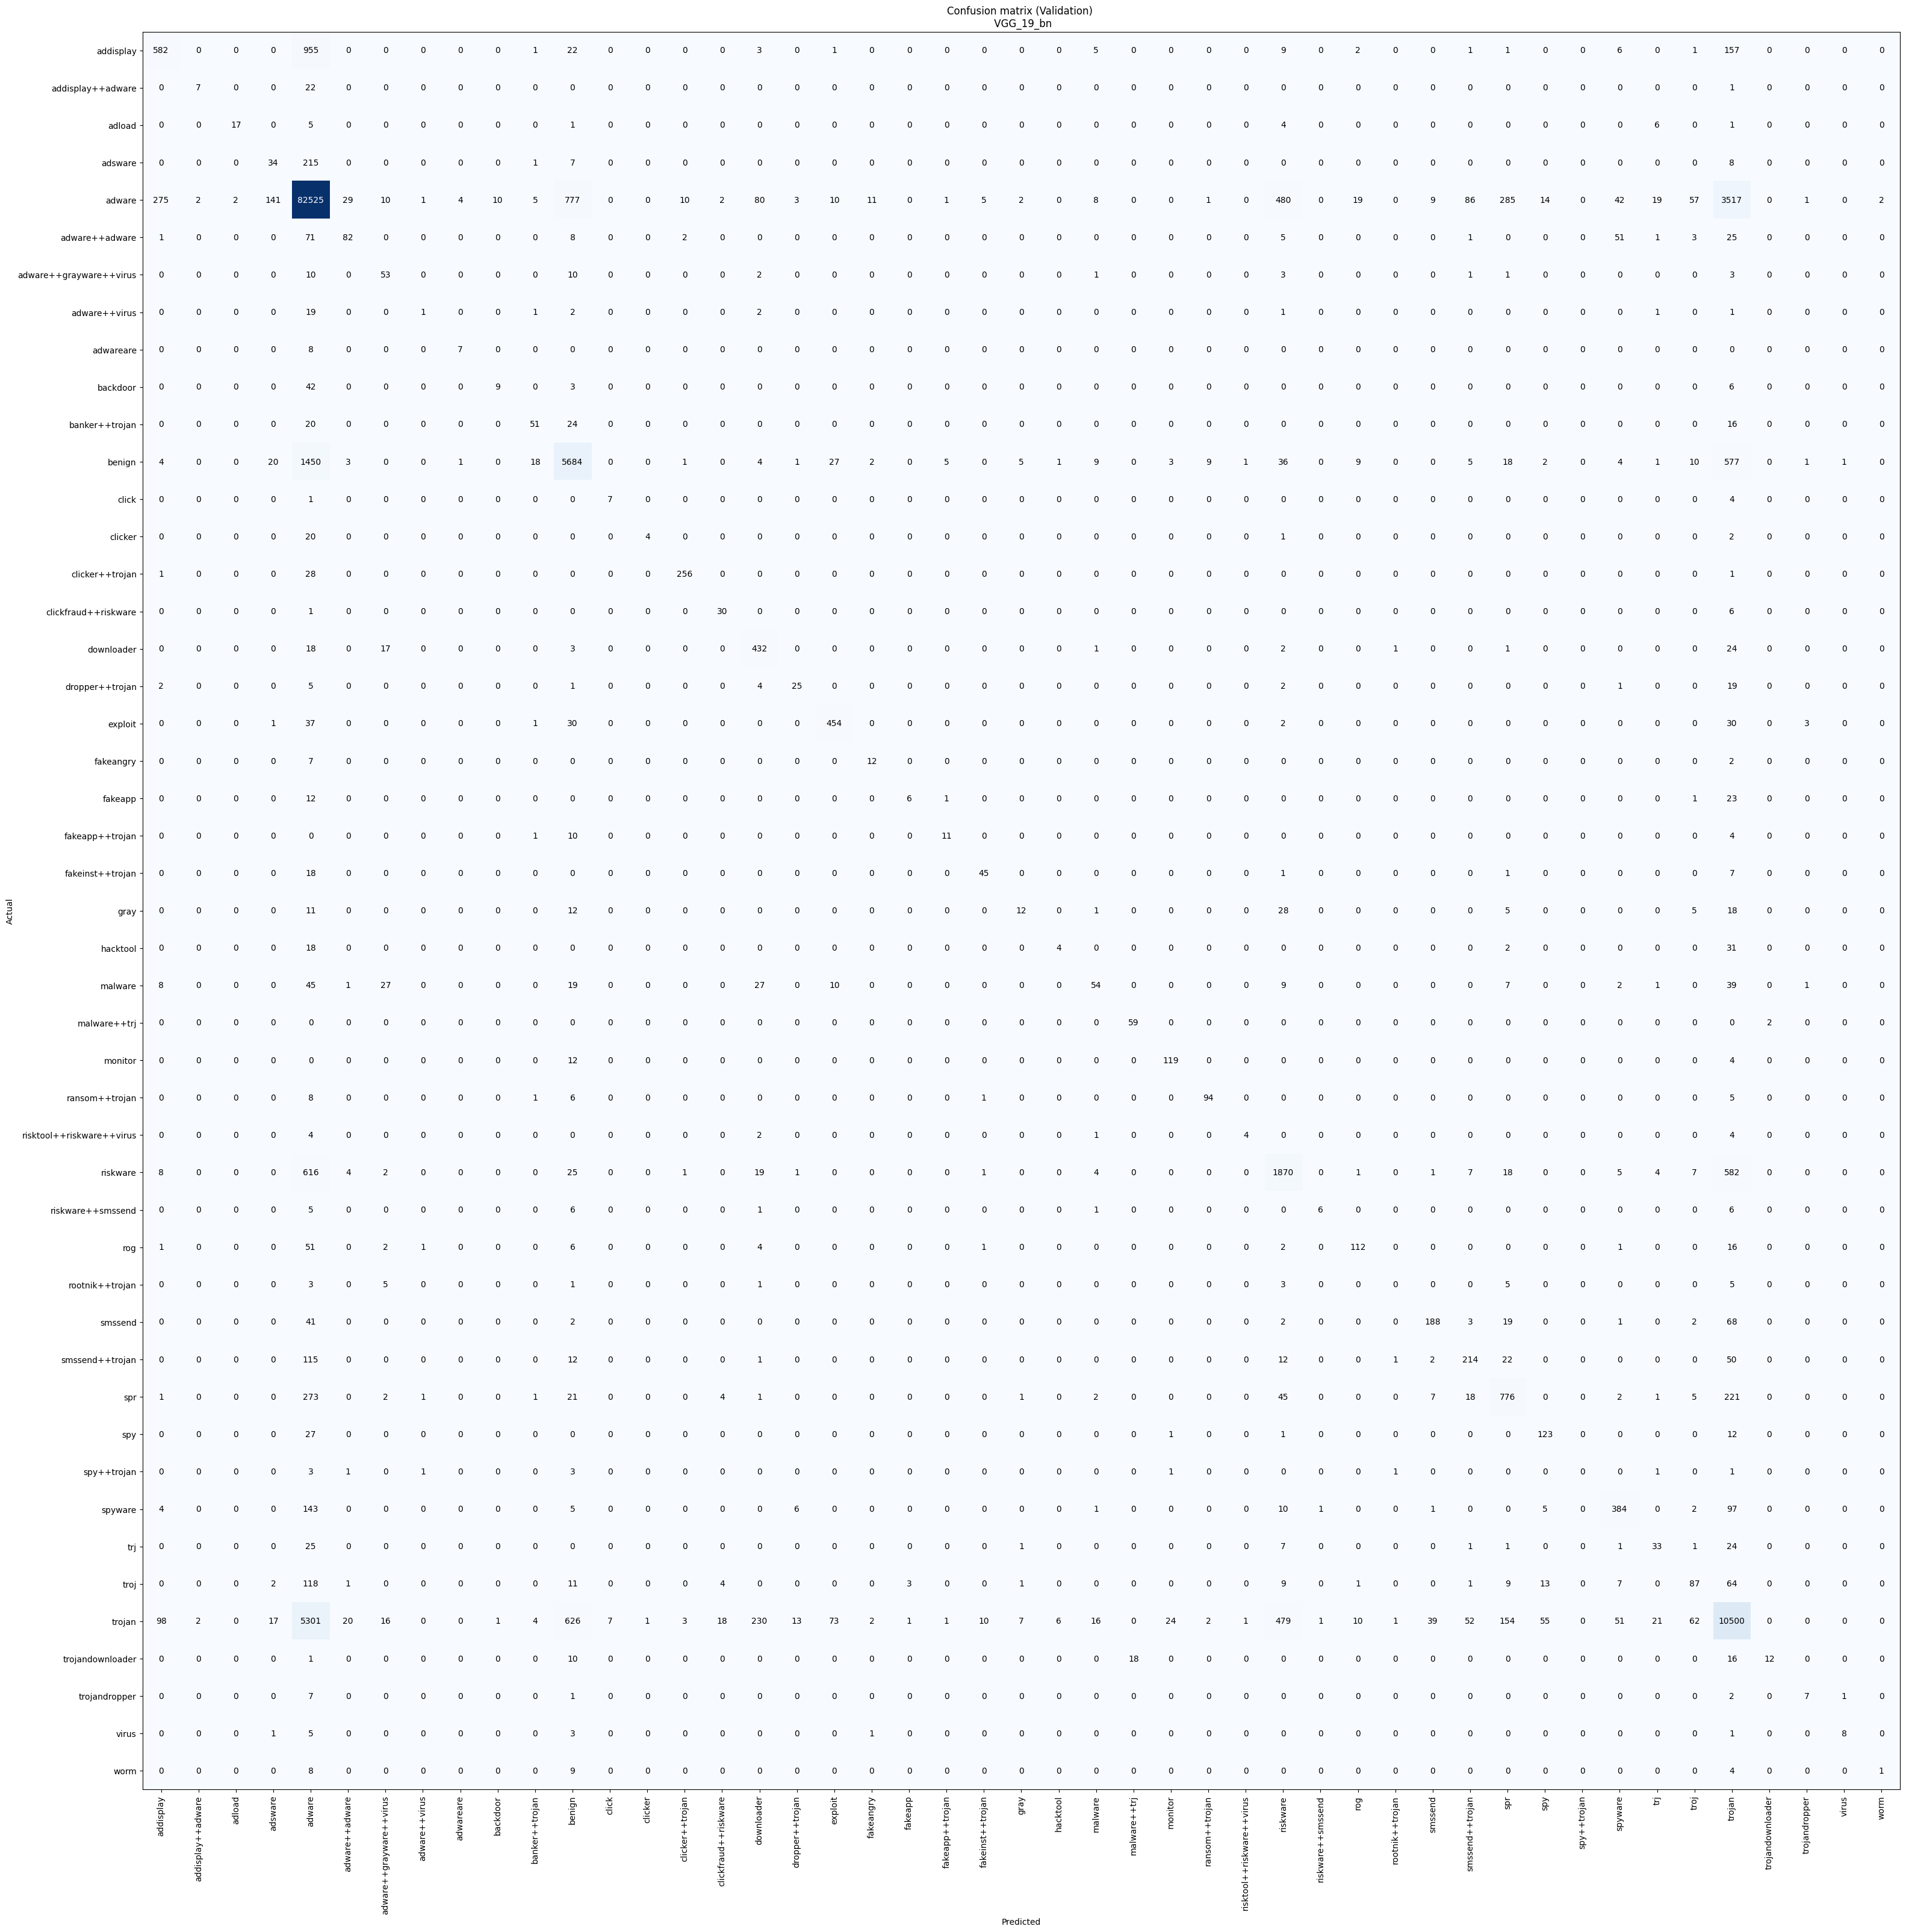

In [224]:
display_confusion_matrix(gts_val, pred_probs_val, class_labels_unique, model_name, "Validation", cf_matrix_fig_size)

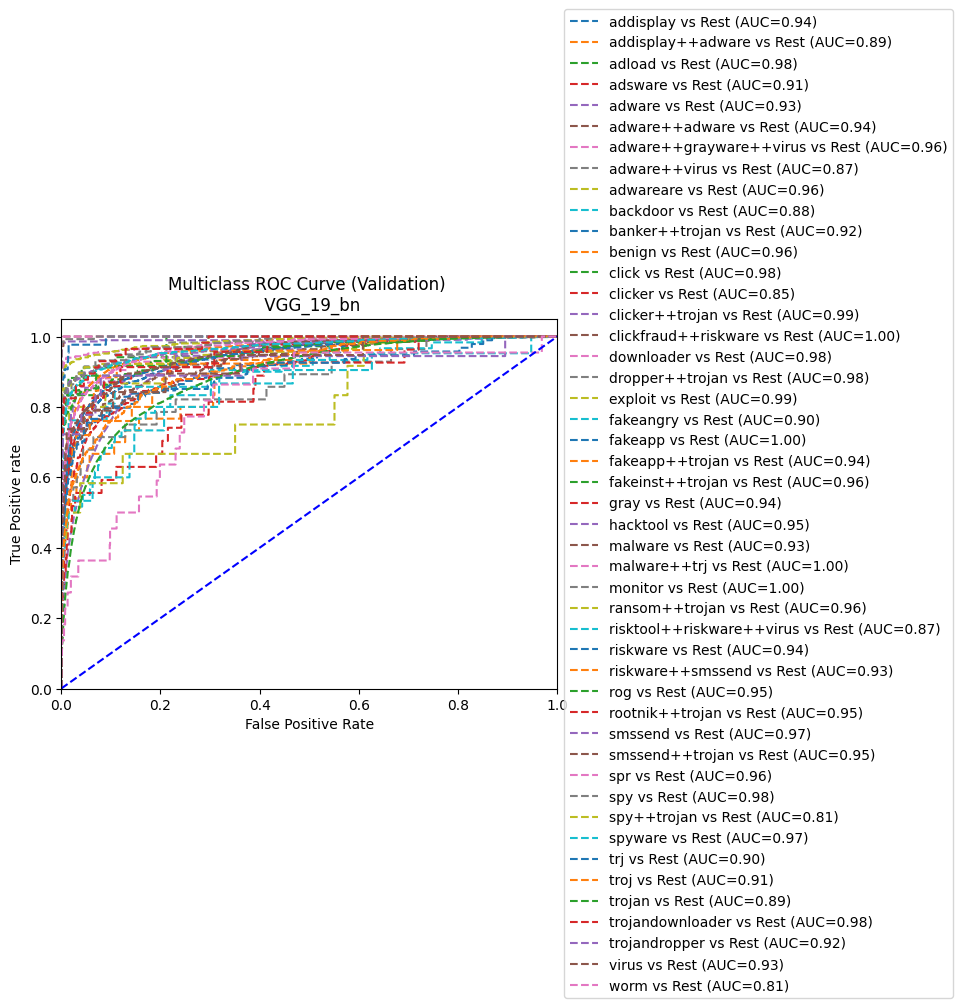

None


In [225]:
get_roc_auc(gts_val, pred_probs_val, class_labels_unique, model_name, "Validation")

## C . Test

In [226]:
display_metrics(gts_test, pred_probs_test)

F1-Score:  0.4739133628336818
Precision: None
Recall:    None


None


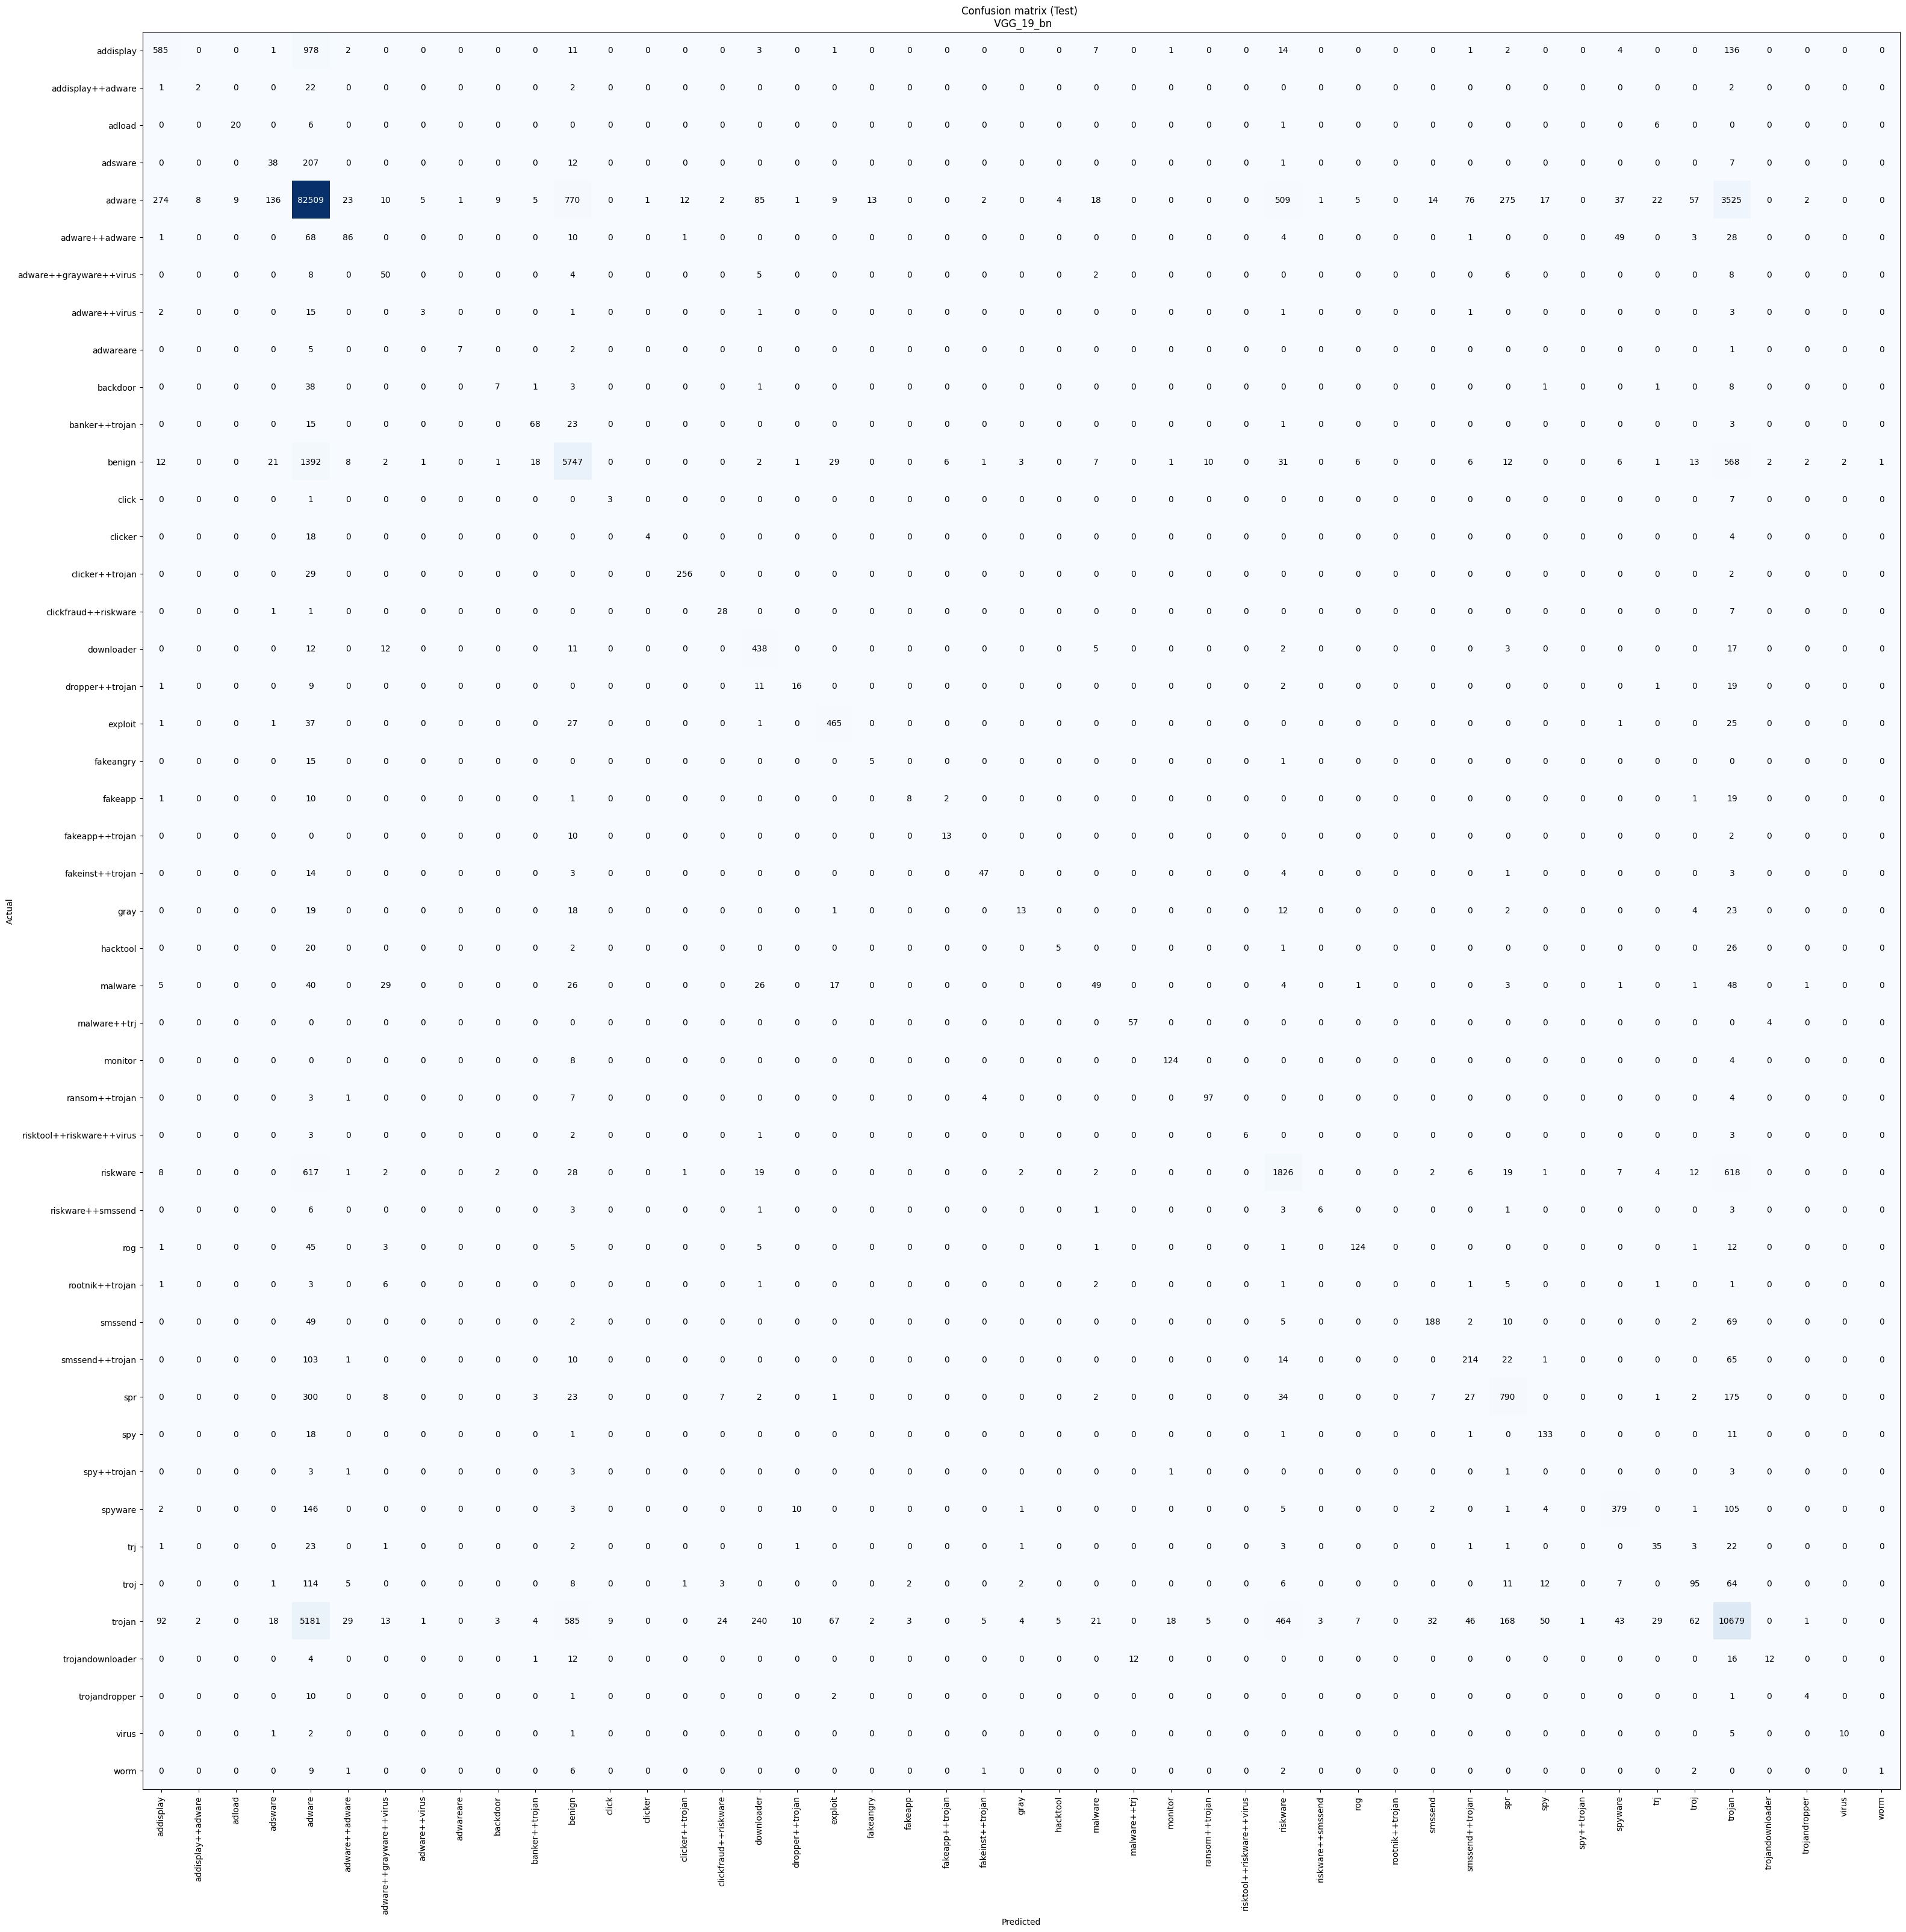

In [227]:
display_confusion_matrix(gts_test, pred_probs_test, class_labels_unique, model_name, "Test", cf_matrix_fig_size)

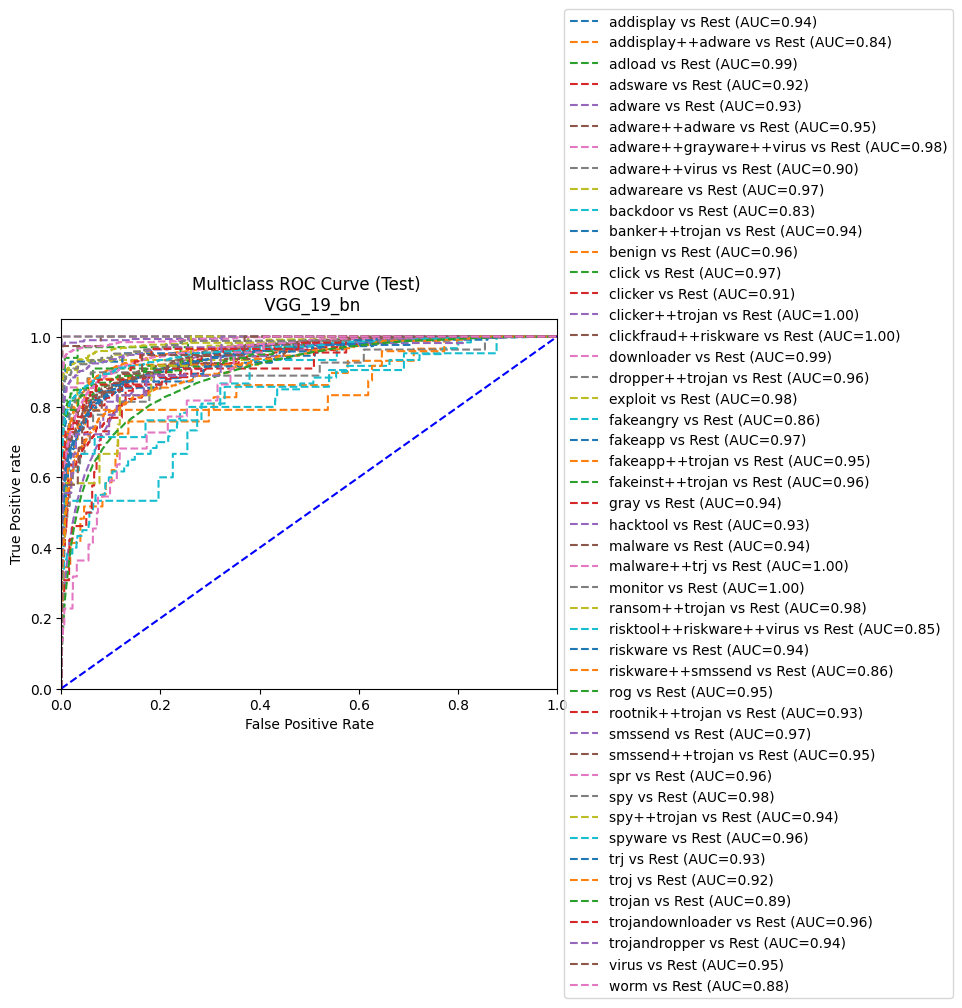

None


In [228]:
get_roc_auc(gts_test, pred_probs_test, class_labels_unique, model_name, "Test")

# 12 . Evaluate Test Results

In [229]:
# *** Evaluate Final Results ***
#
# NOTE: Build loop to evaluate all validation results, then select
#
# 1. Load all Validation results
# 2. For all validation results:
#     a. For each data representation (type, family, binary)
#         1. display results (macro f1-score, macro precision, macro recall)
#         2. track the best f1-score for each data representation (f1-score is primary metric)
# 3. Load Test results for 3 models with best macro f1-score by for each data representation

# 13 . Disconnect and Delete Runtime

In [230]:
# Sleep for 1 minute
# NOTE: Allows figures to fully display before disconnecting.
time.sleep(60)

In [231]:
# Unassign Runtime
runtime.unassign()

# Resources

Original Paper<br />
https://arxiv.org/pdf/2102.01072.pdf<br />

Fastai Tutorials<br />
https://www.youtube.com/watch?v=e8yq1saR7Pk<br />
https://www.youtube.com/watch?v=PHLZCL5h9dc<br />
https://www.youtube.com/@howardjeremyp/videos<br />
https://www.youtube.com/watch?v=-Scs4gbwWXg<br />

Fastai Docs<br />
https://docs.fast.ai/vision.learner.html#vision_learner<br />
https://docs.fast.ai/callback.schedule.html#learner.fine_tune<br />
https://docs.fast.ai/callback.schedule.html#learner.fit_one_cycle<br />
https://docs.fast.ai/callback.data.html#weighteddl<br />
https://docs.fast.ai/losses.html#crossentropylossflat<br />
https://docs.fast.ai/losses.html#focalloss<br />
https://docs.fast.ai/losses.html#focallossflat<br />

Class Imbalance<br />

https://towardsdatascience.com/solving-the-class-imbalance-problem-58cb926b5a0f<br />

https://www.kaggle.com/code/dienhoa/healthy-lung-classification-spectrogram-fast-ai/notebook (Sample Weights - WeightedDL Example)<br />

https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html<br />

https://www.linkedin.com/pulse/some-tricks-handling-imbalanced-dataset-image-m-farhan-tandia (Class Weights - Example)<br />

Learning Curves<br />

https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/<br />